# **Heart Disease Prediction**

## Project Overview  
Cardiovascular disease is one of the leading causes of death worldwide. Early detection and risk prediction can significantly improve patient outcomes.  
This notebook analyzes a heart disease dataset and builds predictive models to classify whether a patient is likely to have heart disease.  

## Dataset Description  
The dataset is a combination of five well-known heart disease datasets (Cleveland, Hungarian, Switzerland, Long Beach VA, and Stalog), merged into a single collection of **918 patient records** with **11 features**.  

- **Target Variable:** `HeartDisease`  
  - `1` → Patient has heart disease  
  - `0` → Patient does not have heart disease  

**Features:**  
- `Age`: Patient age (years)  
- `Sex`: Gender (`M` = Male, `F` = Female)  
- `ChestPainType`: Chest pain type (`TA`, `ATA`, `NAP`, `ASY`)  
- `RestingBP`: Resting blood pressure (mm Hg)  
- `Cholesterol`: Serum cholesterol (mg/dl)  
- `FastingBS`: Fasting blood sugar (`1` if >120 mg/dl, else `0`)  
- `RestingECG`: Resting electrocardiogram results (`Normal`, `ST`, `LVH`)  
- `MaxHR`: Maximum heart rate achieved (60–202 bpm)  
- `ExerciseAngina`: Exercise-induced angina (`Y`, `N`)  
- `Oldpeak`: ST depression induced by exercise  
- `ST_Slope`: Slope of the ST segment (`Up`, `Flat`, `Down`)  

## Data Source  
The dataset is curated from the [UCI Machine Learning Repository](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).  

## Workflow  
This notebook will cover the following steps:  
1. Data exploration and descriptive statistics  
2. Data preprocessing and feature engineering  
3. Exploratory Data Analysis (EDA) with visualizations  
4. Model training and evaluation  
5. Insights and conclusions  

## Heart Disease Prediction — Table of Contents

1. Import Libraries & Load Data
2. Data Profiling
3. Data Cleaning
   - 3.1 Cholesterol
   - 3.2 RestingBP
   - 3.3 Oldpeak
4. Exploratory Data Analysis (EDA)
   - 4.1 Correlation Matrix — Heatmap
   - 4.2 Categorical Univariate (donut_c)
   - 4.3 Continuous Features — Trivariat
   - 4.4 Univariate (Distribution_plot)
5. Feature Engineering
   - 5.1 Domain-Informed Features
   - 5.2 Encoding Categorical Variables
   - 5.3 Feature Interactions & Pairing
6. Train \ Valid \ Test Split — 70 | 20 | 10
7. Feature Importance
   - 7.1 Feature Importance Calculation
   - 7.2 Feature Importance Evaluation
8. Pre-Model Evaluation (Baseline)
   - 8.1 Preparing Pipelines for Baseline
   - 8.2 Evaluating Base Models
9. ML Modeling
   - 9.1 Hypertuning with Optuna
   - 9.2 Compare Models
10. Final ML Model (XGBClassifier)
    - Training & Evaluation
    - Hyperparameters Used
11. Final Insights
    - 11.1 Confusion Matrix
    - 11.2 SHAP (SHapley Additive exPlan.)
    - 11.3 ROC Curve for XGBClassifier
12. Final Summary


# 1. Import Libraries & Load Data

In this section, we import the necessary Python libraries for data handling, visualization, preprocessing, model training, and evaluation.  
We also load the heart disease dataset into a pandas DataFrame for further analysis.


In [1]:
# Explore dataset directory (specific to Kaggle environment)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# === General Utilities ===
import time
import warnings

# === Data Handling ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Model Selection & Evaluation ===
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from scipy.stats import randint, uniform

# === Metrics ===
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)

# === Feature Selection ===
from sklearn.feature_selection import RFE

# === Preprocessing & Pipeline ===
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# === Machine Learning Models ===
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# === Hyperparameter Optimization ===
import optuna

# === Model Interpretation ===
import shap
from sklearn.inspection import permutation_importance

# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load dataset
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')


/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/heart-failure/heart.csv


# **2. Data Profiling**

Before diving into analysis, we first inspect the dataset to understand its structure, data types, and statistical summary.

**Steps in this section:**
1. Preview the first few rows of the dataset  
2. Check dataset dimensions (rows × columns)  
3. Generate descriptive statistics for numerical and categorical features  
4. Review data types and missing values  
5. Separate feature lists into **categorical** and **numerical** variables for further processing


In [2]:
# Preview first 5 rows of the dataset
display(df.head())

# Shape of the dataset (rows, columns)
display(df.shape)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


(918, 12)

In [3]:
# Statistical summary of all columns (numerical + categorical)
df.describe(include='all')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


In [4]:
# Data types and null value check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### 🔍 Data Profiling Insights  

From the dataset summary:  

- **Potential Data Quality Issues:**  
  - `Cholesterol` contains **zero values**, which are physiologically not possible.  
  - `RestingBP` has **zero values**, which are also unrealistic.  
  - `Oldpeak` includes **negative values**, which should not occur.  

- **Categorical Features:**  
  - `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`, and the target variable `HeartDisease`.  

- **Numerical Features (Continuous):**  
  - `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, and `Oldpeak`.  

- **Initial Observations:**  
  - Average patient age is **53.5 years** (range: 28–77).  
  - Resting blood pressure averages **132 mm Hg**, though some invalid zero values exist.  
  - Cholesterol levels average **198 mg/dl**, but again some invalid zeros are present.  
  - Maximum heart rate achieved ranges from **60 to 202 bpm**.  
  - `HeartDisease` target variable shows a fairly balanced distribution (approx. 55% positive cases).  

In [5]:
# Separate categorical (object) and numerical features
col_obj = [c for c in df.columns if df[c].dtype == 'object']
col_num = [c for c in df.columns if df[c].dtype in ['int64', 'float64']]
orginal = [c for c in df.columns]

# **3. Data Cleaning**

From the profiling step, we identified potential data quality issues:  
3.1. `Cholesterol` has zero values (not physiologically possible)  
3.2. `RestingBP` has zero values (not possible)  
3.3. `Oldpeak` has negative values (not possible)  


## 3.1 Cholesterol

- Around **10% of values are zero**, which is unrealistic.  
- Maximum observed value is **603**, which is abnormally high.  
- Based on domain knowledge, cholesterol values below **75 mg/dl** or above **600 mg/dl** are treated as invalid.  

To correct these values, a two-step imputation strategy was applied:  

**Step (i): Grouped Mean Imputation**  
- Imputed invalid values using the mean cholesterol levels of patients grouped by:  
  - `ChestPainType`  
  - `RestingECG`  
  - `Sex`  
  - `FastingBS`  
- These features were chosen because they showed distinctive mean cholesterol values during exploratory checks (not shown here for brevity).  

**Step (ii): Global Median Imputation**  
- After grouped imputation, **1 record** remained invalid.  
- This record was filled using the **global median cholesterol value** (more robust than mean for skewed data).  

 This ensures all `Cholesterol` values are realistic and domain-appropriate.

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Cholesterol,0.0,0.0,134.8,190.0,209.0,223.0,238.2,257.0,276.0,305.0,603.0


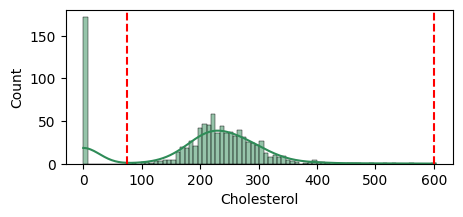

In [6]:
n = np.arange(0.0,1.01,0.1).tolist()
chol_quantiles = df['Cholesterol'].quantile(n).to_frame().T
display(chol_quantiles)
plt.figure(figsize=(5,2))
sns.histplot(df['Cholesterol'], bins=80, color='seagreen', kde=True)
plt.axvline(x=75, linestyle='--', color='red') # lower realistic bound
plt.axvline(x=600, linestyle='--', color='red') # upper realistic bound
plt.show()

In [7]:
# Step 1: Compute grouped mean for valid cholesterol values
group_mean = df.loc[(df['Cholesterol']>75) & (df['Cholesterol']<600)].groupby(['ChestPainType', 'RestingECG', 'Sex', 'FastingBS'])['Cholesterol'].mean()
group_mean_map = group_mean.to_dict()

# Step 2: Mask invalid cholesterol values
mask = (df['Cholesterol']<= 75) | (df['Cholesterol']>=600)

# Step 3: Apply grouped mean imputation
df.loc[mask,'Cholesterol'] = df.loc[mask].apply(lambda row: group_mean_map.get((row['ChestPainType'],row['RestingECG'],row['Sex'],row['FastingBS']),np.nan), axis=1)

# Step 4: Handle remaining missing values with global median
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())

# Final check
df['Cholesterol'].isna().sum()

0

## **3.2 RestingBP**

- Only **one record** has a `RestingBP` value of **0**, which is physiologically impossible.  
- Instead of simply dropping the row or imputing with a global mean/median, I manually inspected this case.  

**Approach:**  
- Created `MaxHR` bins to compare the patient’s profile against similar cases.  
- Cross-checked related features (`MaxHR`, `Oldpeak`, `ST_Slope`) with the abnormal record.  
- Based on similar patients, a plausible resting blood pressure value is **120 mm Hg**.  

**Justification:**  
- The global median of `RestingBP` is **130 mm Hg**, which is close to 120.  
- Imputing 120 aligns with typical physiological ranges and preserves data integrity without introducing strong bias.  

 Final Decision: Replace the invalid `RestingBP = 0` with **120**.


In [8]:
# Create bins for MaxHR to find comparable patient groups
df['max_hr_bins'] = pd.cut(df['MaxHR'], bins=10, labels=[f'bins{i}' for i in range(1, 11)])

# Inspect the row with RestingBP = 0
df[df['RestingBP'] == 0]

# Check patients with similar characteristics
df.loc[(df['RestingBP'] != 0) &(df['max_hr_bins'] == 'bins7') &(df['Oldpeak'] == 1.5) &(df['ST_Slope'] == 'Flat')]

# Compare with overall median RestingBP
print('Global Median:',df.loc[df['RestingBP'] != 0, 'RestingBP'].median())

# Impute value 120 for the invalid case
df['RestingBP'].replace(0, 120, inplace=True)

Global Median: 130.0


## **3.3 Oldpeak**

- `Oldpeak` represents ST depression induced by exercise, so it cannot take **negative values**.  
- A small number of records contain negative values.  

**Approach:**  
- Replaced negative values with the **median of all valid (≥ 0) Oldpeak values**.  
- Median was rounded to **1 decimal place** to match the scale of the feature.  

 Final Decision: All negative `Oldpeak` values were imputed with the median (≈ 0.6).  


In [9]:
#since oldpeak can't be negative

old_peak_median = round(df.loc[df['Oldpeak']>=0,'Oldpeak'].median(),1)
df.loc[df['Oldpeak']<0,'Oldpeak'] = old_peak_median
df.loc[df['Oldpeak']<0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,max_hr_bins


# **4. Exploratory Data Analysis (EDA)**

In this section, we explore the dataset to better understand relationships, distributions, and patterns that may influence heart disease prediction.  

The analysis covers:  

1. **Correlation Matrix**  
   - Heatmap visualization to assess linear relationships among numerical features.  

2. **Categorical Variables**  
   - Univariate: Donut charts to show class distribution.  
   - Bivariate: Bar plots to analyze categorical features against the target variable.  

3. **Continuous Variables**  
   - Trivariate: Line plots to explore trends across multiple features.  
   - Bivariate: Violin/Box plots to compare distributions between classes.  
   - Univariate: Distribution plots for individual continuous features.  

We also define a set of **custom colors** for consistent, visually appealing plots.


In [10]:
# Custom color palettes for plots
from matplotlib.colors import to_rgba

# Two main contrasting colors with transparency
colors = [to_rgba('crimson',0.75), to_rgba('skyblue',0.8)]

# A muted palette for additional categorical variables
base_colors = [ '#B2DF8A', '#FB9A99', '#FDBF6F', '#CAB2D6', '#FFFF99', '#1F78B4', '#33A02C', '#E31A1C', '#FF7F00'] # muted

## 4.1 Correlation Matrix — Heatmap  

To investigate the linear relationships among features, we construct a correlation matrix.  

- **Preprocessing:** Encode categorical (object-type) columns into numeric form using `LabelEncoder`.  
- **Correlation Computation:** Compute Pearson correlation on all numeric features.  
- **Visualization:** Use a heatmap with masking to highlight only the lower triangle for clarity.  

This helps identify multicollinearity, redundant features, and the most influential predictors for heart disease.


In [11]:
# Step 1: Encode categorical variables for correlation analysis
from sklearn.preprocessing import LabelEncoder
df_enc = df.copy()

for col in col_obj:
    le = LabelEncoder()
    df_enc[col+'_encoded'] = le.fit_transform(df[col])
    print(f'{col} : {dict(zip(le.classes_, le.transform(le.classes_)))}') # to see mapping

Sex : {'F': 0, 'M': 1}
ChestPainType : {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
RestingECG : {'LVH': 0, 'Normal': 1, 'ST': 2}
ExerciseAngina : {'N': 0, 'Y': 1}
ST_Slope : {'Down': 0, 'Flat': 1, 'Up': 2}


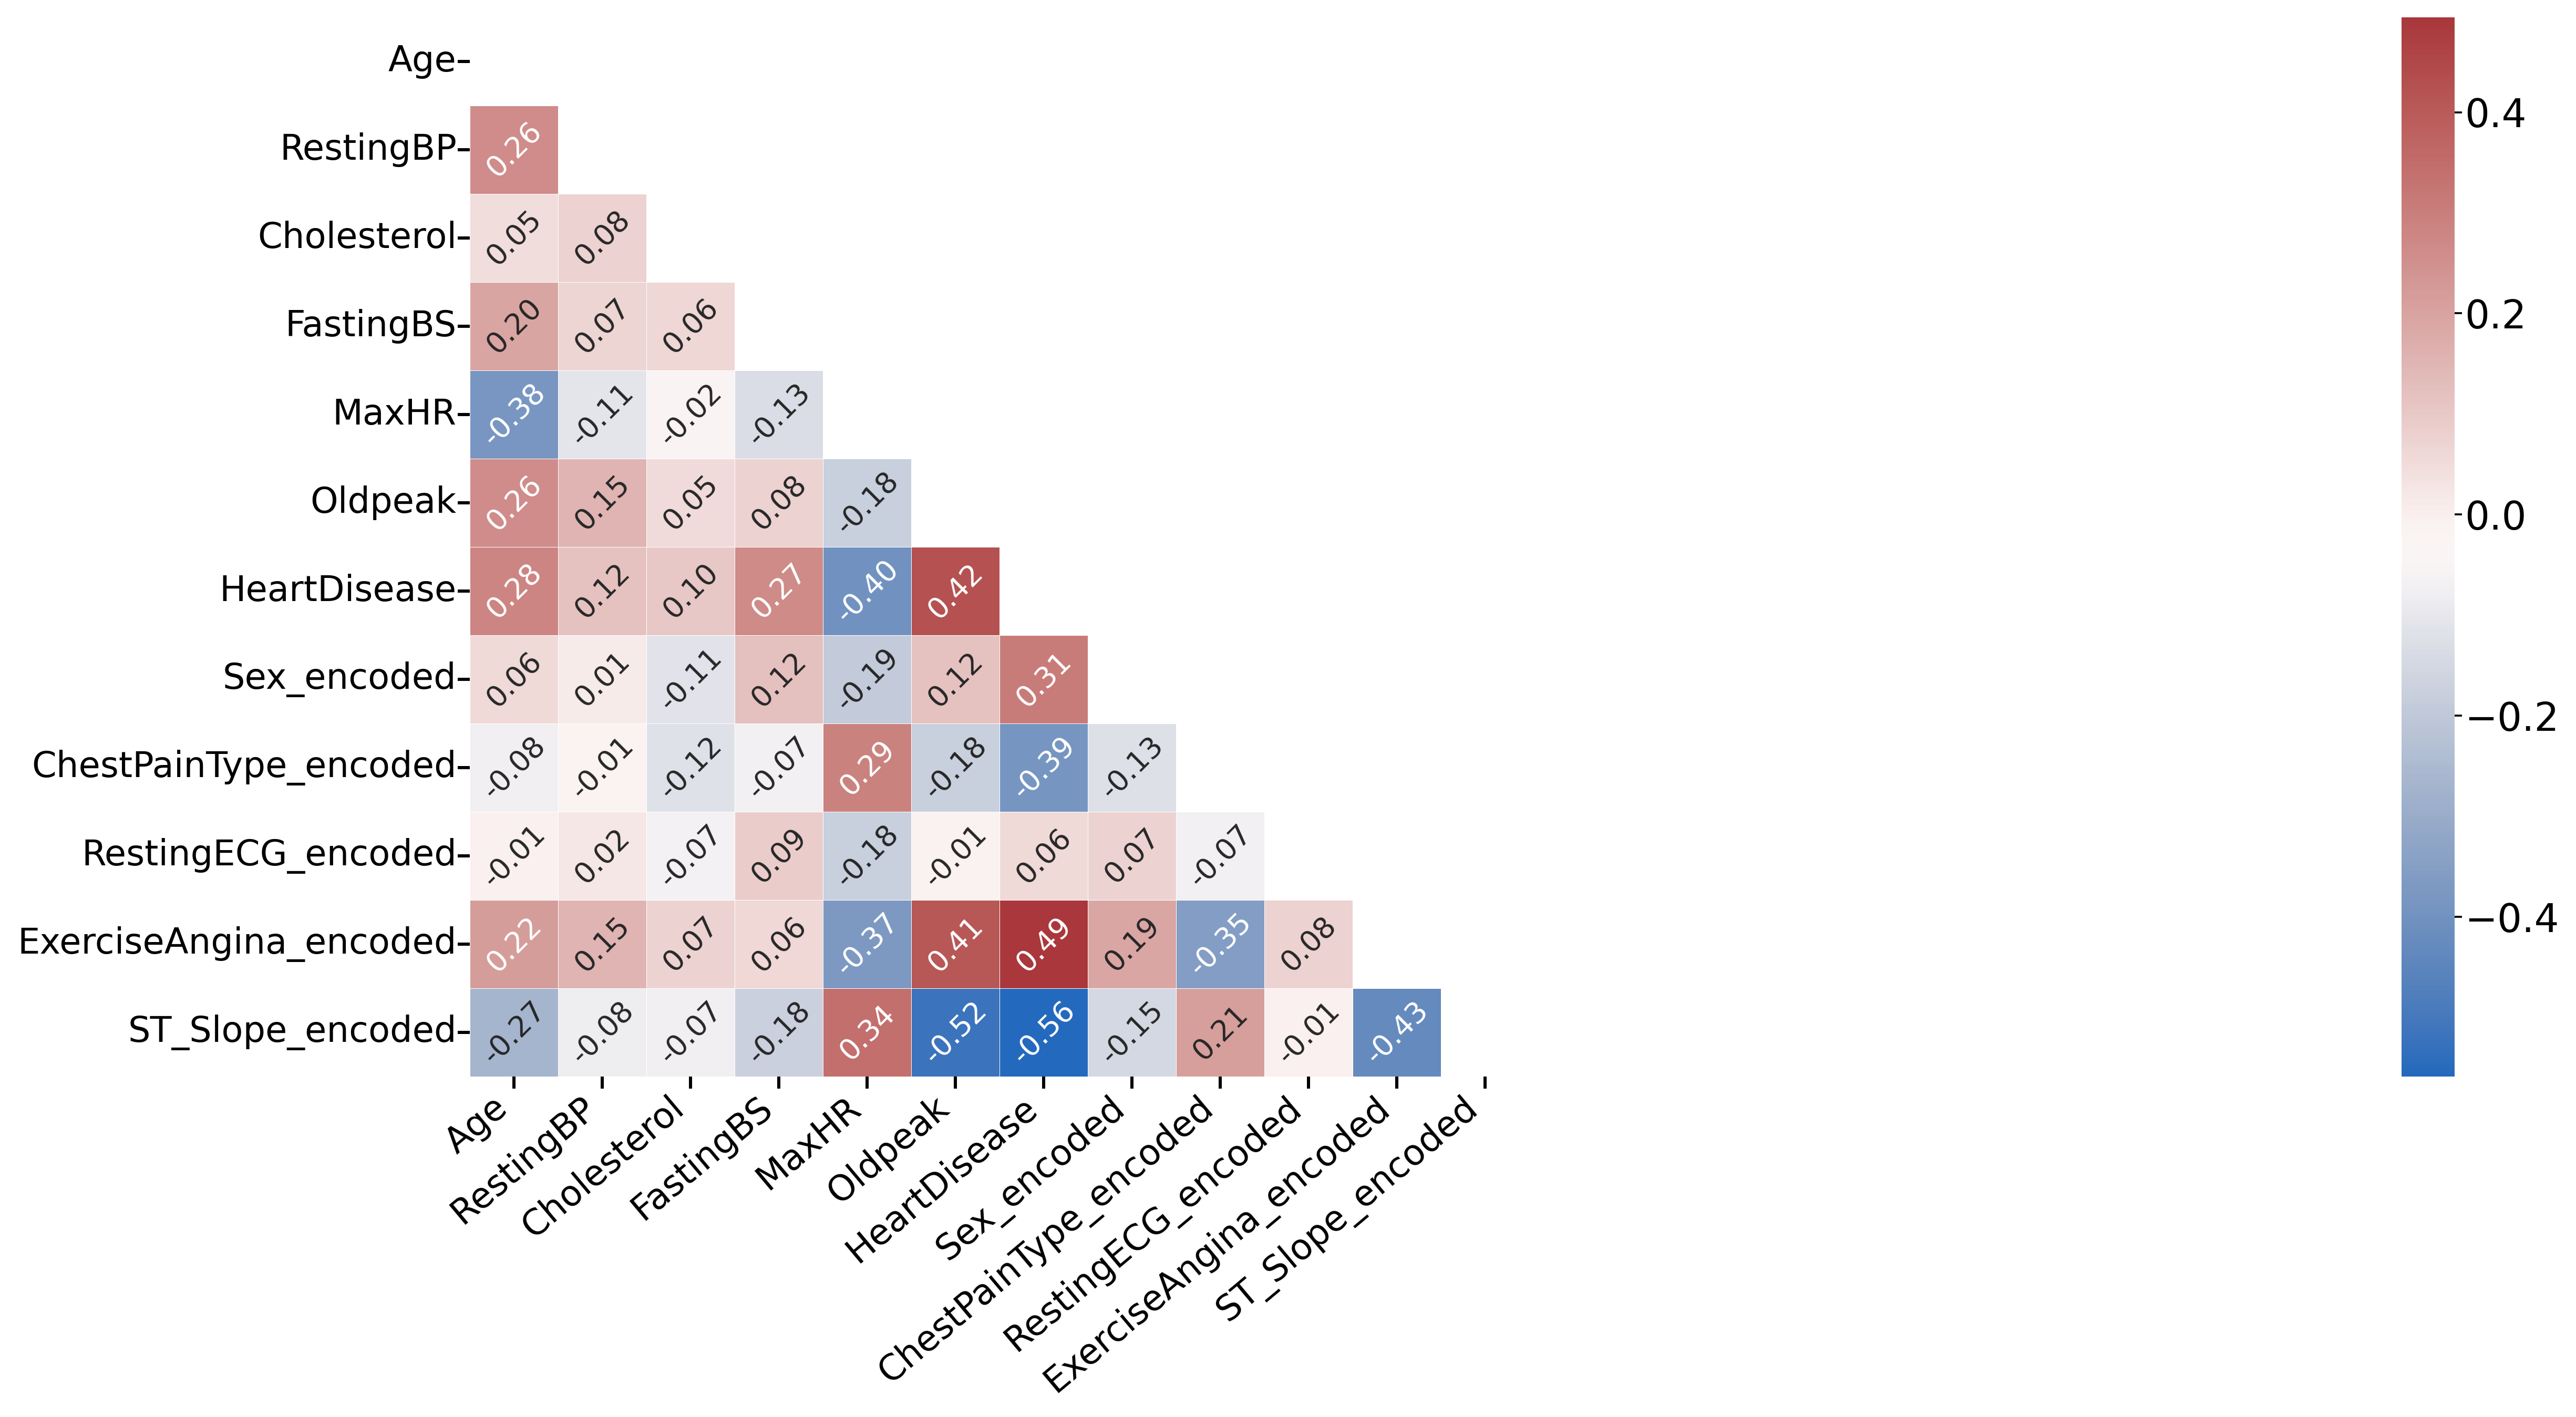

In [12]:
# Step 2: Select only numeric columns for correlation matrix
col_num_enc=[c for c in df_enc.columns if df_enc[c].dtype in ['int64','float64']]

# Step 3: Compute correlation matrix
df_enc_corr = df_enc[col_num_enc].corr()

# Step 4: Create mask to hide upper triangle (avoid duplicate values)
mask_df_enc = np.triu(np.ones_like(df_enc_corr, dtype=bool))

# Step 5: Plot heatmap
plt.figure(figsize=(100,8.2),dpi=333)
ax=sns.heatmap(data=df_enc_corr, mask = mask_df_enc, cmap='vlag', xticklabels=True, yticklabels=True, square = True, annot = True, fmt = '0.2f', annot_kws={'size':12,'rotation':45}, linewidth=0.2)
# Aesthetic adjustments
plt.xticks(fontsize=14.5,rotation=40,ha='right') ; plt.yticks(fontsize=14.5,rotation=0) 
ax.tick_params(axis='both', which='both', width=1.3, length=5, pad=0.5) 
# Configure colorbar
cbar=ax.collections[0].colorbar ; cbar.ax.tick_params(labelsize=16, length=3, width=0.8,pad=1)
plt.tight_layout()
plt.show()

**Insights from Heatmap:**  

- Correlation with HeartDisease
  - Features with high positive correlation: `ExerciseAngina_encoded` and `Oldpeak`.  
  - Features with strong negative correlation: `Max_HR`, `ChestPainType_encoded` and `ST_Slope_encoded`.  
  - Near-zero correlation: `RestingECG_encoded`.  


## 4.2 **Categorical** Univariate (`donut_chart`) & Bivariate(`bar_plot`)

In this section, we analyze **categorical variables** using two complementary plots:  
- **Donut Chart (Univariate):** Shows the distribution of each category.  
- **Bar Plot (Bivariate):** Shows the proportion of *Heart Failure vs. No Heart Failure* across categories.  

This combination helps us understand both the overall class distribution and how each category relates to the target variable.


#### 4.2.1 Data Preparation
We create a helper function `cats()` to summarize the target distribution (`HeartDisease`) for each categorical feature.  


In [13]:
# Create a new result DataFrame with proper metrics for donut chart
def cats(df,colll):
    g = df.groupby(colll)['HeartDisease']
    r = pd.DataFrame({'heartfail_per_type': g.mean(),'type_ratio': g.count() / df.shape[0]}).reset_index()
    r['Heart Failure'] = r['heartfail_per_type']*r['type_ratio']
    r['No Heart Failure'] = r['type_ratio'] - r['Heart Failure']
    return r

#### 4.2.2 Plot Function
We define a custom function `donut_bar()` that:  
- Plots a **stacked bar chart** (Heart Failure vs. No Heart Failure per category).  
- Plots a **donut chart** showing the category distribution.  

Both plots are displayed side-by-side for easier interpretation.  


In [14]:
def donut_bar(df,coll):
    
    data = cats(df,coll)    ## called function to create dataset corresponding to column
    fig, axs = plt.subplots(1,2,figsize=(12,5))    ## plot side by side

    # ----------------------------------------------- Bar Plot -----------------------------------------------------
    # 1. barplot data:
    bar_df = data[[coll,'Heart Failure', 'No Heart Failure']].set_index(coll)
    hf = (data['Heart Failure'] / data['type_ratio']).values; nhf = abs(1 - hf)
    percent_labels = np.round(np.stack([hf,nhf], axis=1).flatten(),2)

    # 2. plot:
    bar_df.plot(kind='bar', stacked = False, color=colors,ax=axs[0])
    axs[0].bar_label(axs[0].containers[0], labels = percent_labels[0::2], padding=1)
    axs[0].bar_label(axs[0].containers[1], labels = percent_labels[1::2], padding=1)
    axs[0].set(ylabel='Proportion', title=f'Heart Failure vs No Heart Failure by {coll}')
    axs[0].tick_params(axis='x', rotation=0)

    # ----------------------------------------------- Donut Chart ---------------------------------------------------
    # 1. Donut data:
    labels=data[coll]; type_ratio = data['type_ratio'].values

    #plot
    axs[1].axis('equal')
    axs[1].pie(type_ratio,
               radius = 0.7,
               labels = labels,
               autopct = '%1.1f%%',
               labeldistance = 0.85,
               colors = base_colors[:len(labels)],
               wedgeprops = dict(width=0.4, edgecolor='white', linewidth=5),
            )
    axs[1].set_title(f"{coll} Distribution ")
    axs[1].legend()


    fig.suptitle(f"{coll} Distribution & Heart Failure Breakdown",fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

#### 4.2.3 Plot Execution
We iterate through the main categorical features:  
`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`  

Each feature is visualized using the `donut_bar()` function.  


----- Sex ----- 


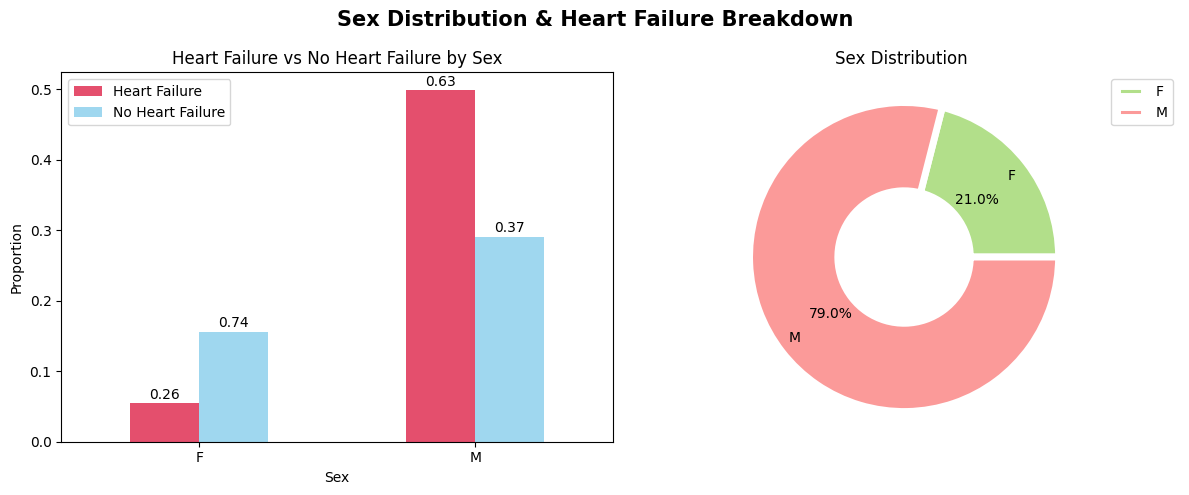


----- ChestPainType ----- 


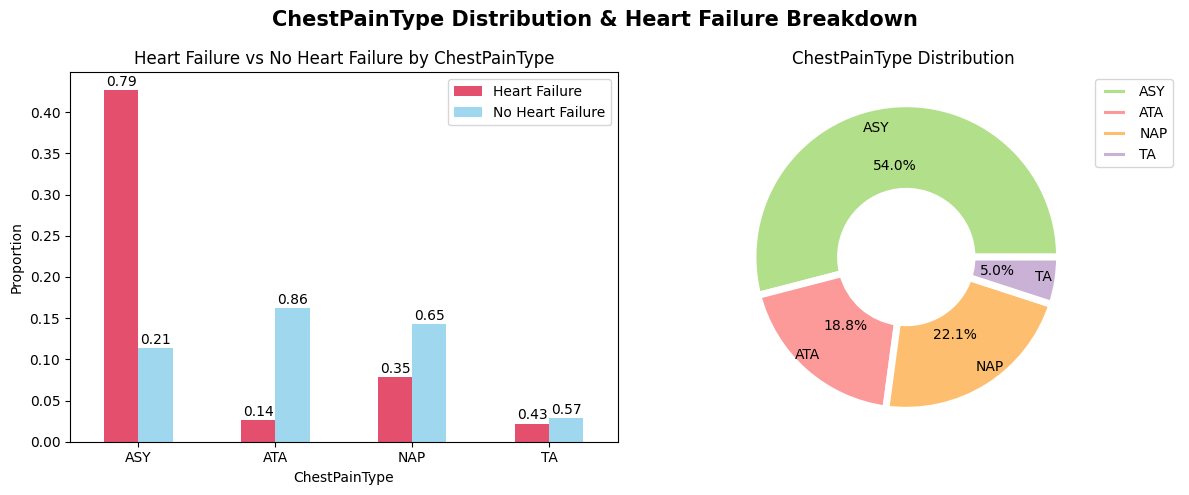


----- FastingBS ----- 


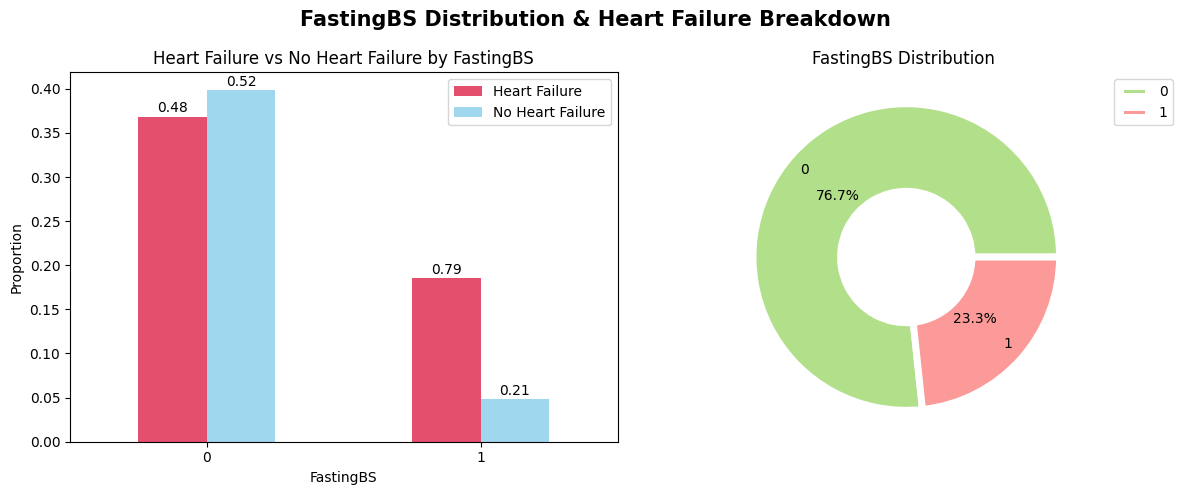


----- RestingECG ----- 


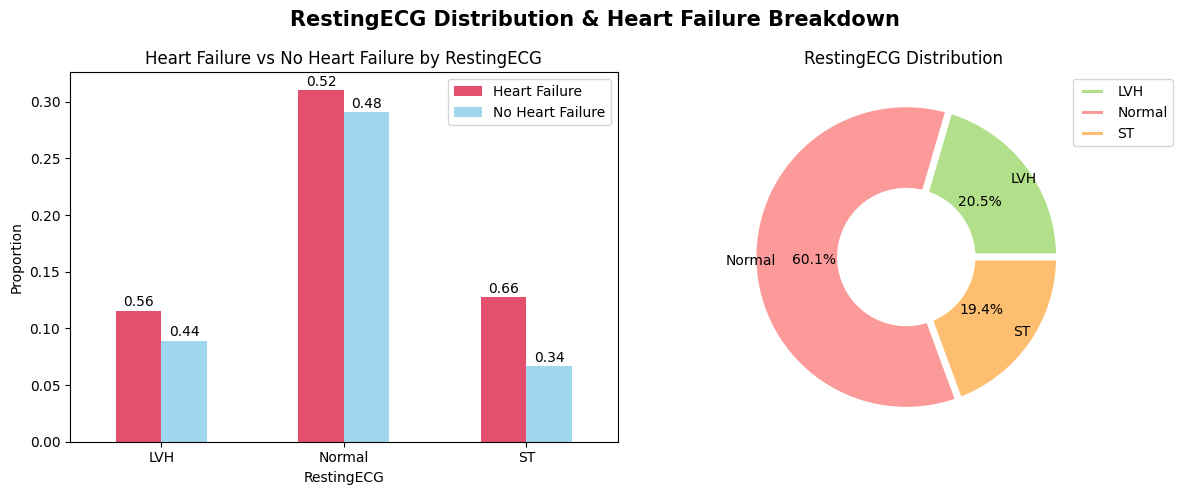


----- ExerciseAngina ----- 


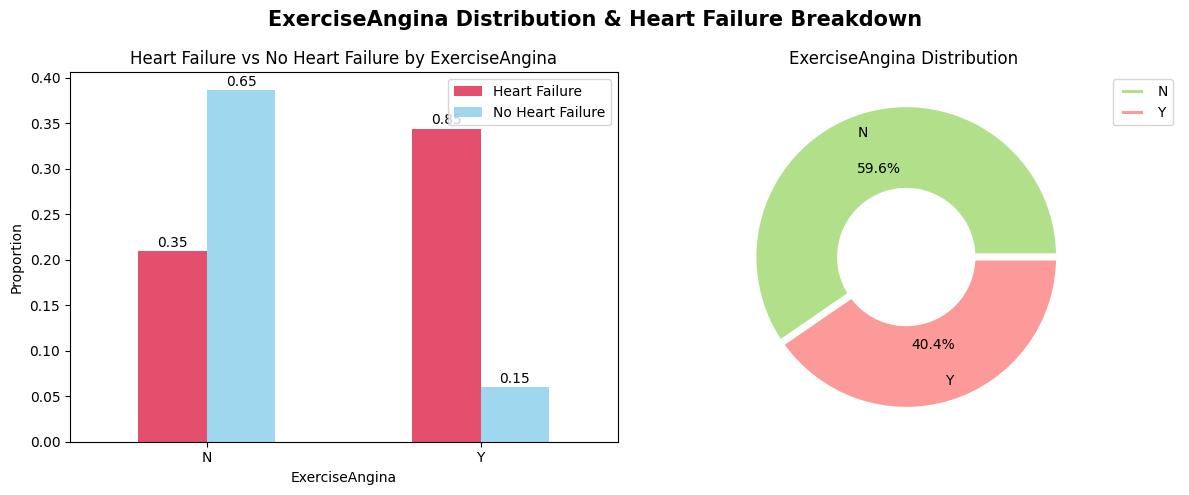


----- ST_Slope ----- 


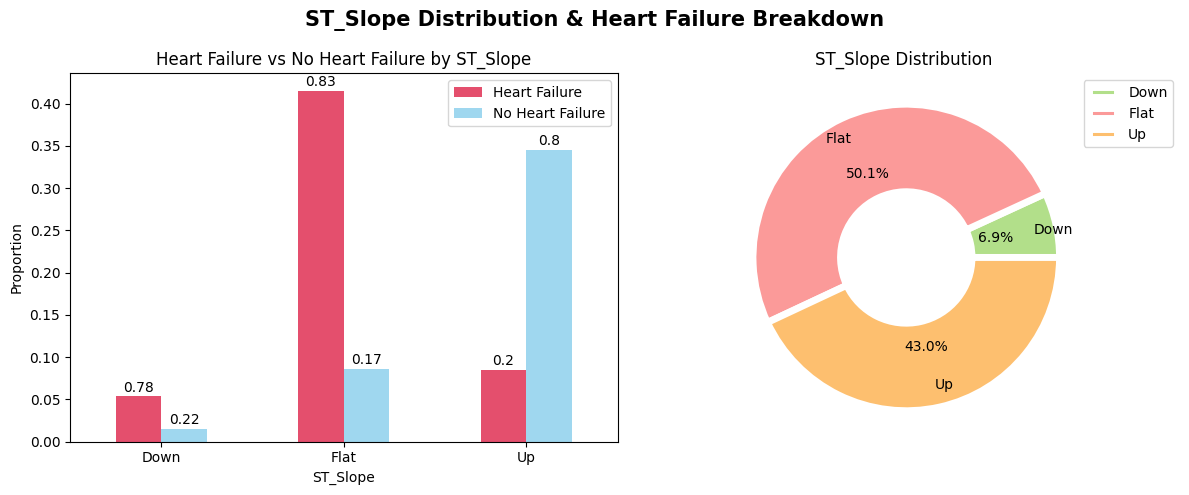

In [15]:
col_cat = ['Sex','ChestPainType','FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope']
for c in col_cat:
    print(f"\n----- {c} ----- ")
    donut_bar(df,c)

#### Insights from Categorical Univariate & Bivariate Analysis  

- **Sex**  
  - Females (26%) show **lower heart failure prevalence** compared to males (63%).  
  - Males (79%) dominate the dataset, but males are relatively more vulnerable.  

- **Chest Pain Type**  
  - **Asymptomatic (ASY)** cases (54%) are strongly associated with heart disease (79%).  
  - **Typical Angina (ATA)** has the **lowest risk** (14% heart disease).  
  - **Non-Anginal Pain (NAP)** (22%) shows moderate prevalence (35%).  
  - **Typical Angina (TA)** is least frequent (5%) with a 43% heart disease rate.  

- **Fasting Blood Sugar (FastingBS)**  
  - Patients with **FBS > 120 mg/dl** (23.3%) have **much higher prevalence** (79%) vs. normal (48%).  
  - Elevated fasting blood sugar is a **significant risk factor**.  

- **Resting ECG**  
  - **ST abnormalities** (19.4%) and **LVH** (20.5%) show higher prevalence (66% and 56% respectively).  
  - **Normal ECG** (60.1%) still has ~52% prevalence, indicating ECG alone isn’t strongly discriminative.  

- **Exercise Angina**  
  - Presence of angina during exercise is a **critical risk marker** – 85% prevalence when **Yes**, compared to 35% when **No**.  

- **ST Slope**  
  - **Flat (50.1%)** and **Down (6.9%)** slopes are strongly associated with heart disease (83% and 78%).  
  - **Up slope (43%)** is protective, with only 20% prevalence.  

 **Overall Insight:**  
Categorical analysis highlights strong risk indicators for heart disease:  
- **ASY chest pain type**, **high fasting blood sugar**, **exercise-induced angina**, and **flat/down ST slopes**.  
- These features show significant separability and are likely **important predictors** in modeling.  


## 4.3 Continuous Features — Trivariate & Bivariate Analysis  

Here, we analyze the continuous numerical features with respect to **HeartDisease**.  
- **Trivariate (Line Plot):** Age vs Feature split by HeartDisease → helps us see how the feature changes across age and disease status.  
- **Bivariate (Violin & Box Plot):** Feature distribution split by HeartDisease → shows spread, median differences, and variability.  

We also calculate the **median difference (Δ)** between HeartDisease groups to measure discriminatory power.  


#### 1. plot_function

In [16]:
def continuous_plot(df,col):
    
    """
    Function to plot continuous features against HeartDisease.
    Creates:
    1. Line plot (Feature vs Age, split by HeartDisease)
    2. Violin plot (Feature distribution by HeartDisease)
    3. Box plot (Feature distribution by HeartDisease)
    
    Also computes and displays median values for both groups and their difference (Δ).
    """
    
    fig = plt.figure(figsize=(20,10))
    gs = fig.add_gridspec(2,2) # define 2x2 grid for subplots

    # --- Line plot (Age vs Feature) ---
    ax1 = fig.add_subplot(gs[0,:]) # top row (span both columns)
    sns.lineplot(data=df, x='Age', y=col,hue='HeartDisease', ax=ax1)
    ax1.grid(True, axis='both', which='both' ,linestyle='--', alpha=0.5)

    # --- Violin plot (distribution by HeartDisease) ---
    ax2 = fig.add_subplot(gs[1,0]) # bottom-left
    sns.violinplot(data=df, x='HeartDisease', y=col, ax=ax2)

    # --- Box plot (distribution by HeartDisease) ---
    ax3 = fig.add_subplot(gs[1,1]) # bottom-right
    sns.boxplot(data=df, x='HeartDisease', y=col, ax= ax3)

    # --- Compute group medians ---
    median_1 = df.loc[df['HeartDisease']==1, col].median()
    median_0 = df.loc[df['HeartDisease']==0, col].median()
    diff = abs(median_1 - median_0)
    
    # --- Title with medians and Δ ---
    fig.suptitle(f"{col} vs Age for HeartDisease", fontsize=20, y=1.10, fontweight='bold')
    fig.text( 0.5,1.02,
              f"{col}_Median (HD=1): {median_1:.1f}  |  {col}_Median (HD=0): {median_0:.1f}  |  Δ: {diff:.1f}",
              ha='center', fontsize=14, fontweight='normal' )
    
    plt.tight_layout()
    plt.show()

#### 2. Apply function to continuous numerical columns

Continuous variables selection  

- We exclude `Age` (used as x-axis) and `HeartDisease` (target) from the continuous feature list.  
- Remaining continuous variables will be looped through the `continuous_plot` function.  



----- RestingBP ----- 


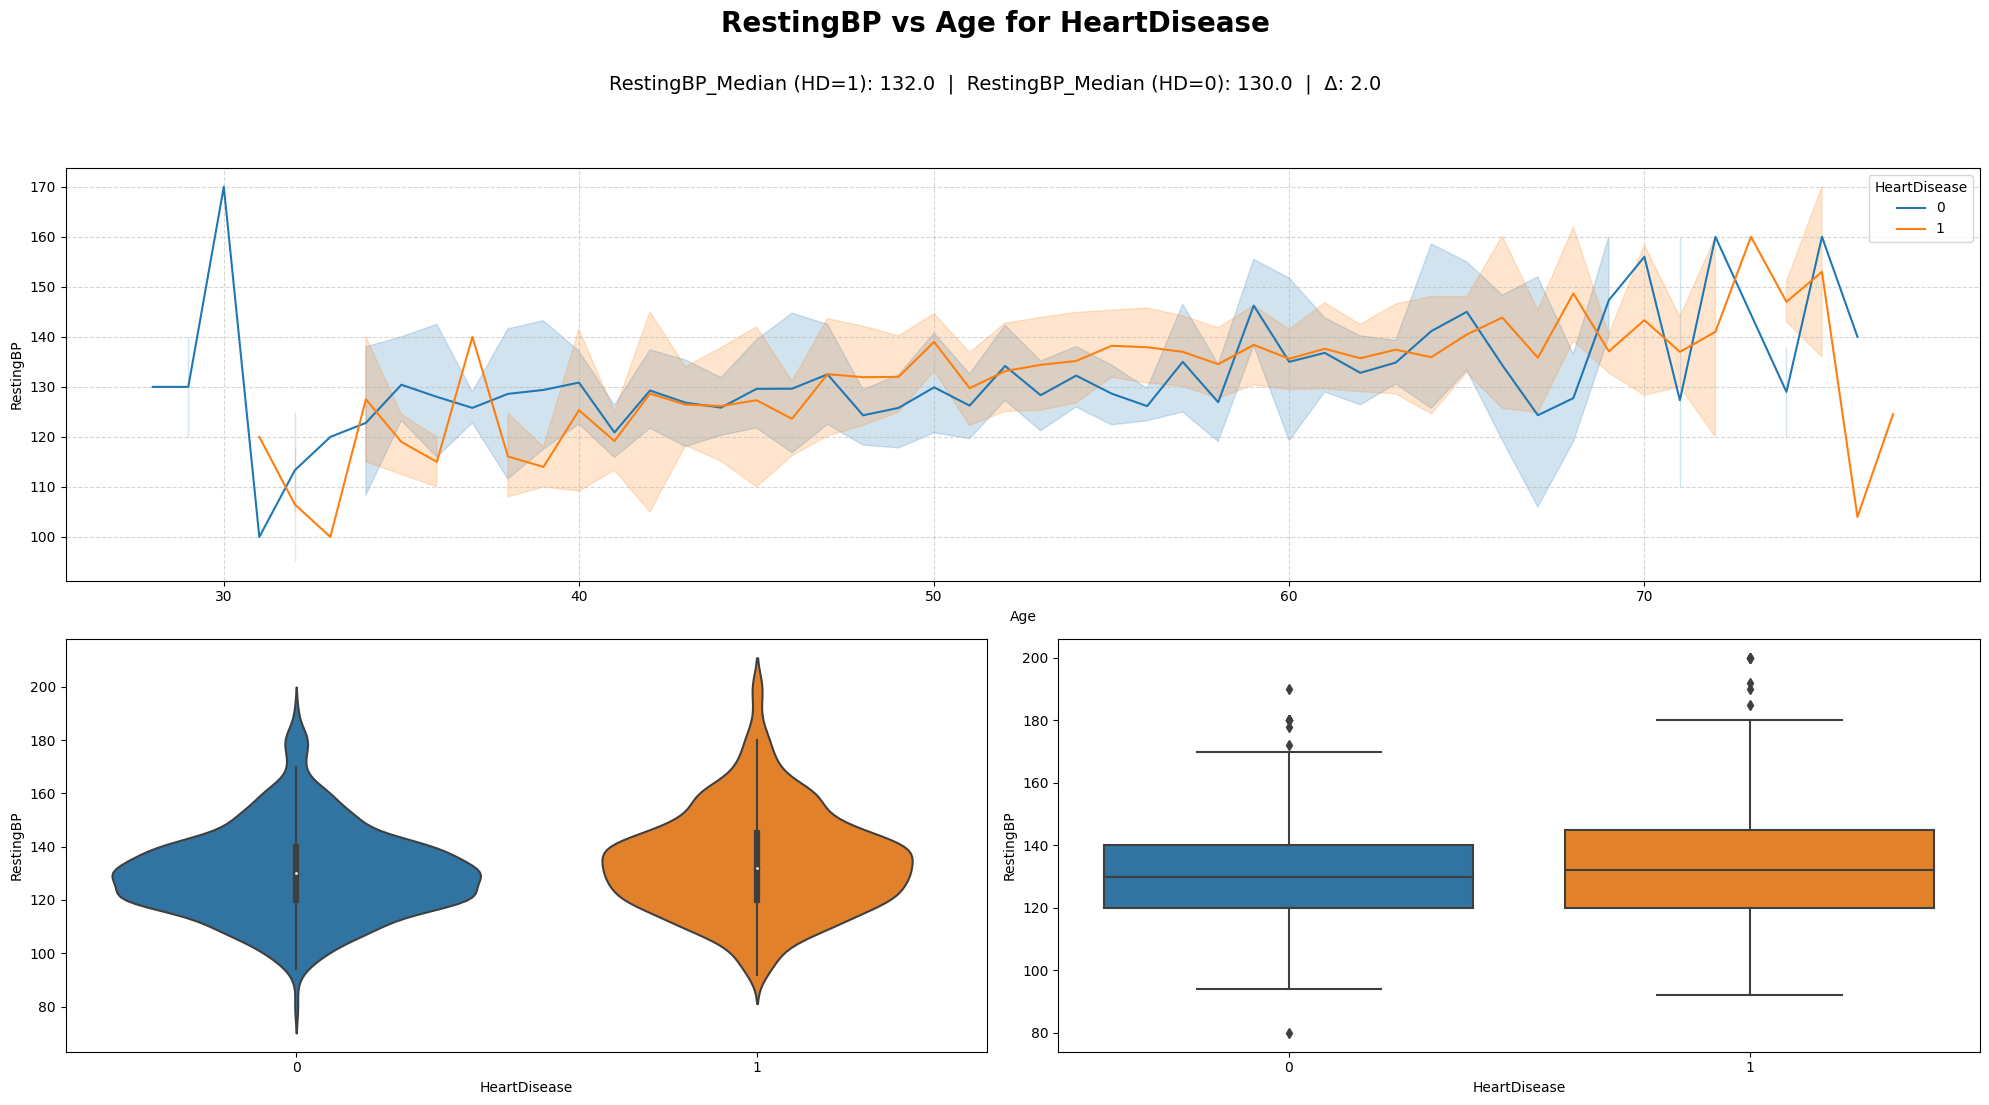




----- Cholesterol ----- 


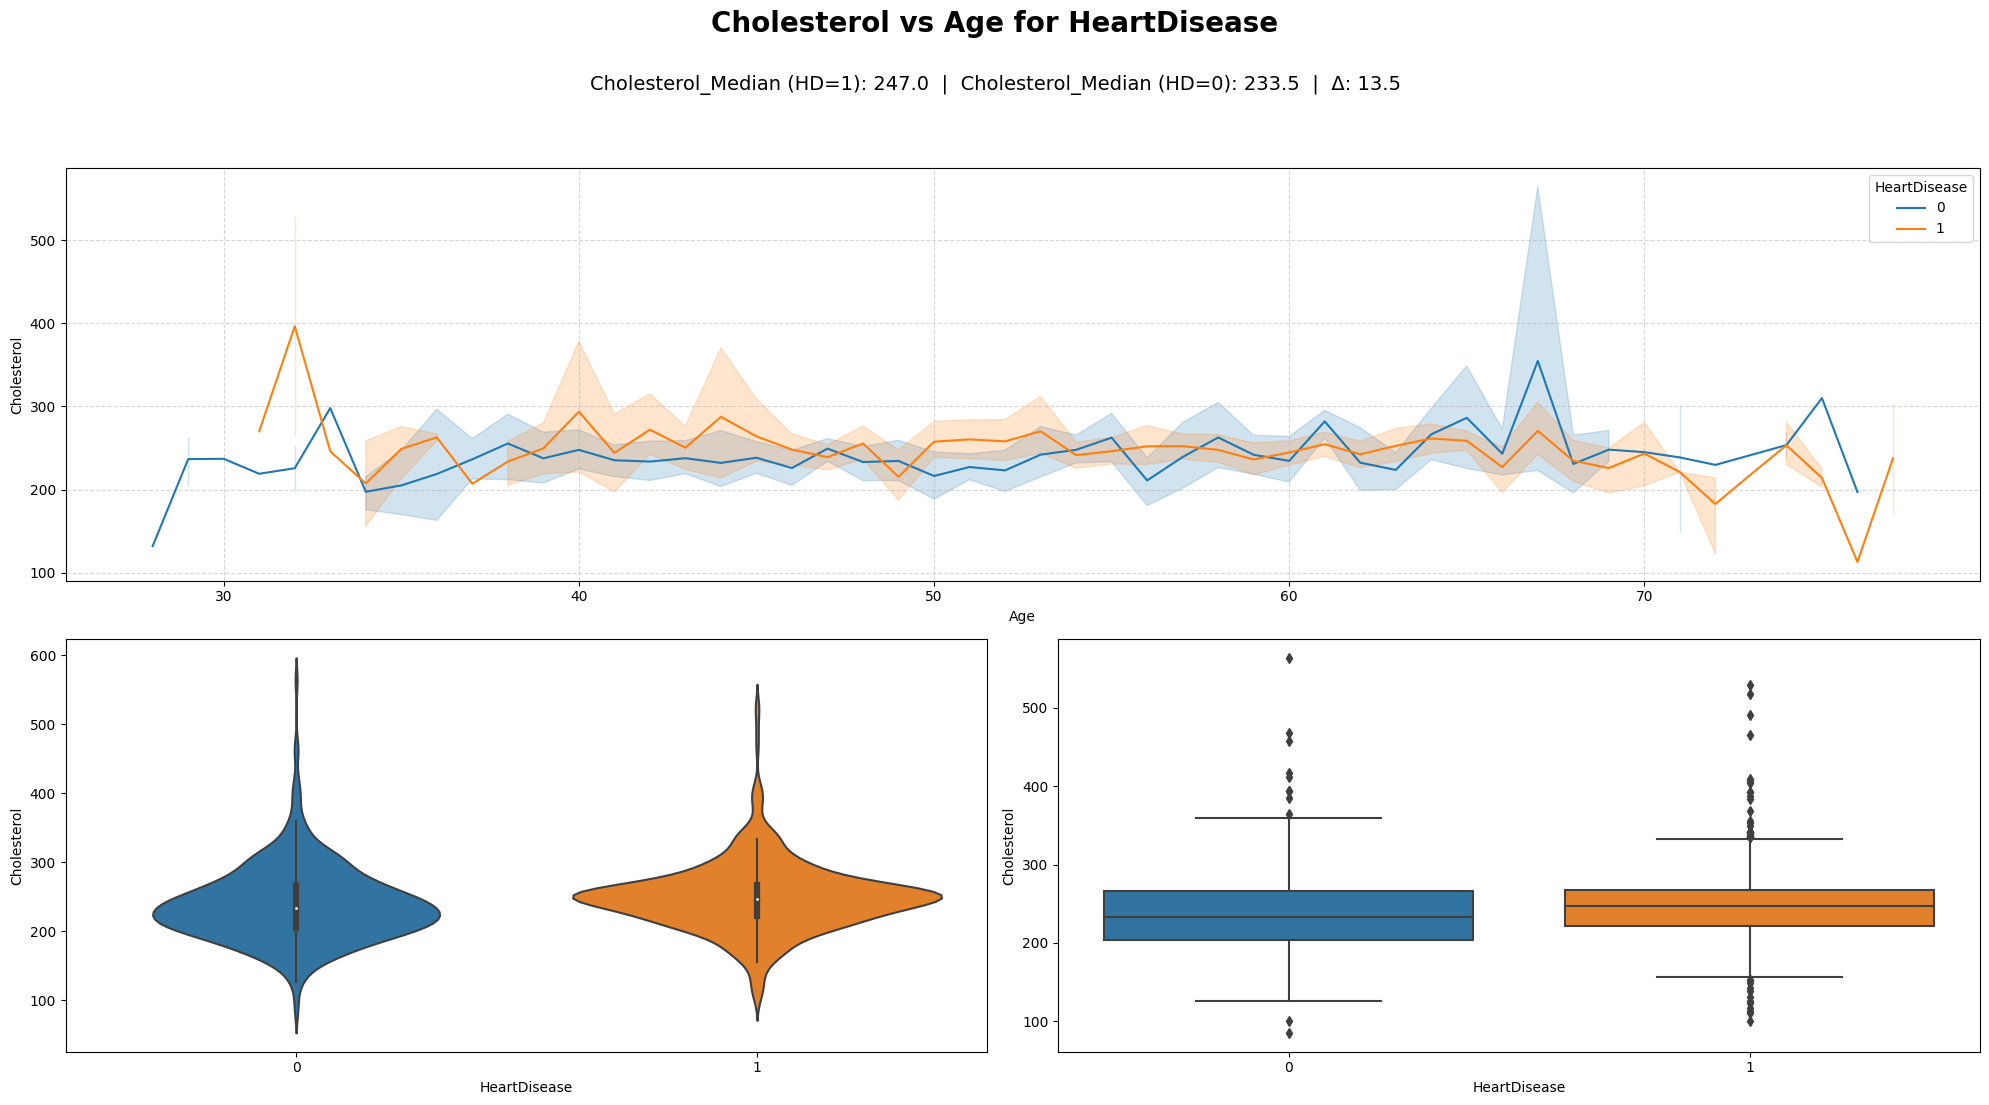




----- FastingBS ----- 


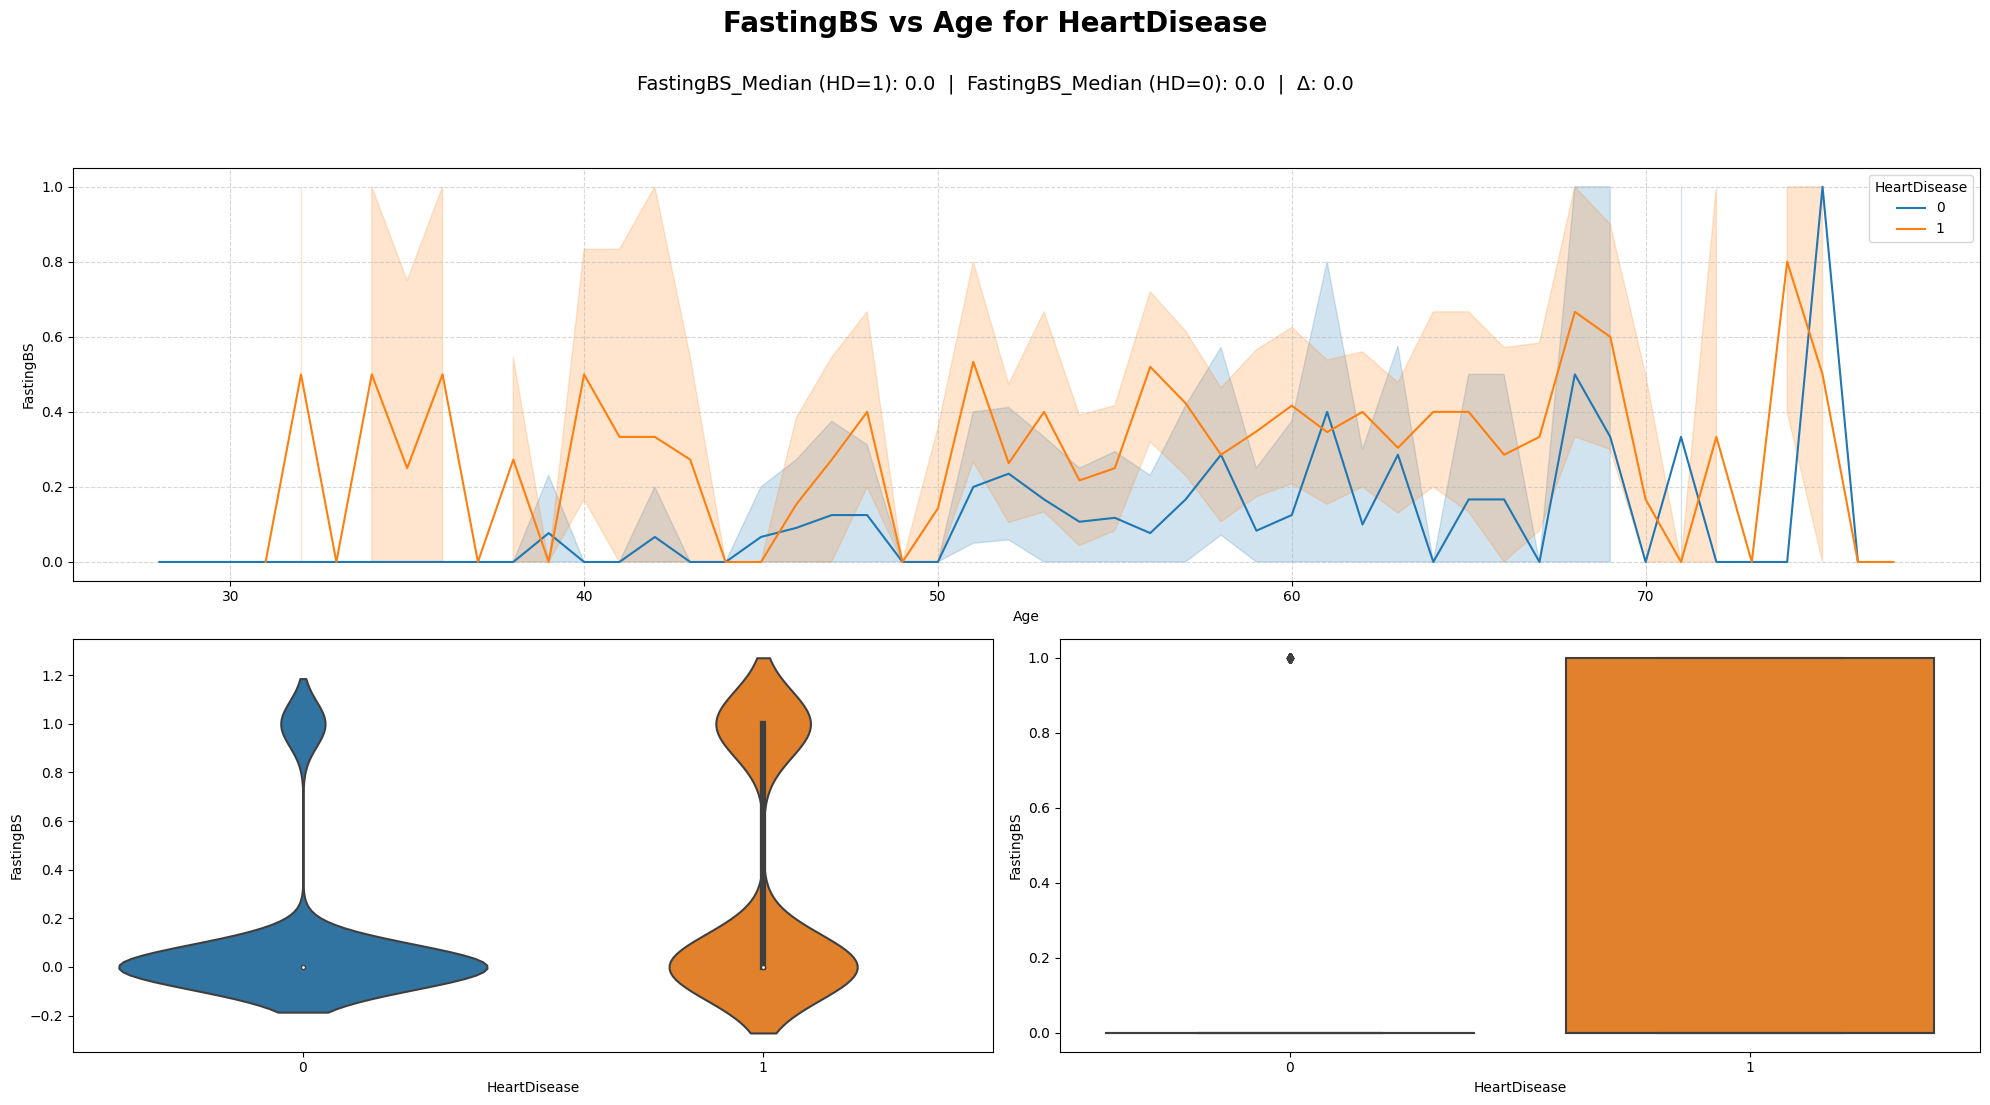




----- MaxHR ----- 


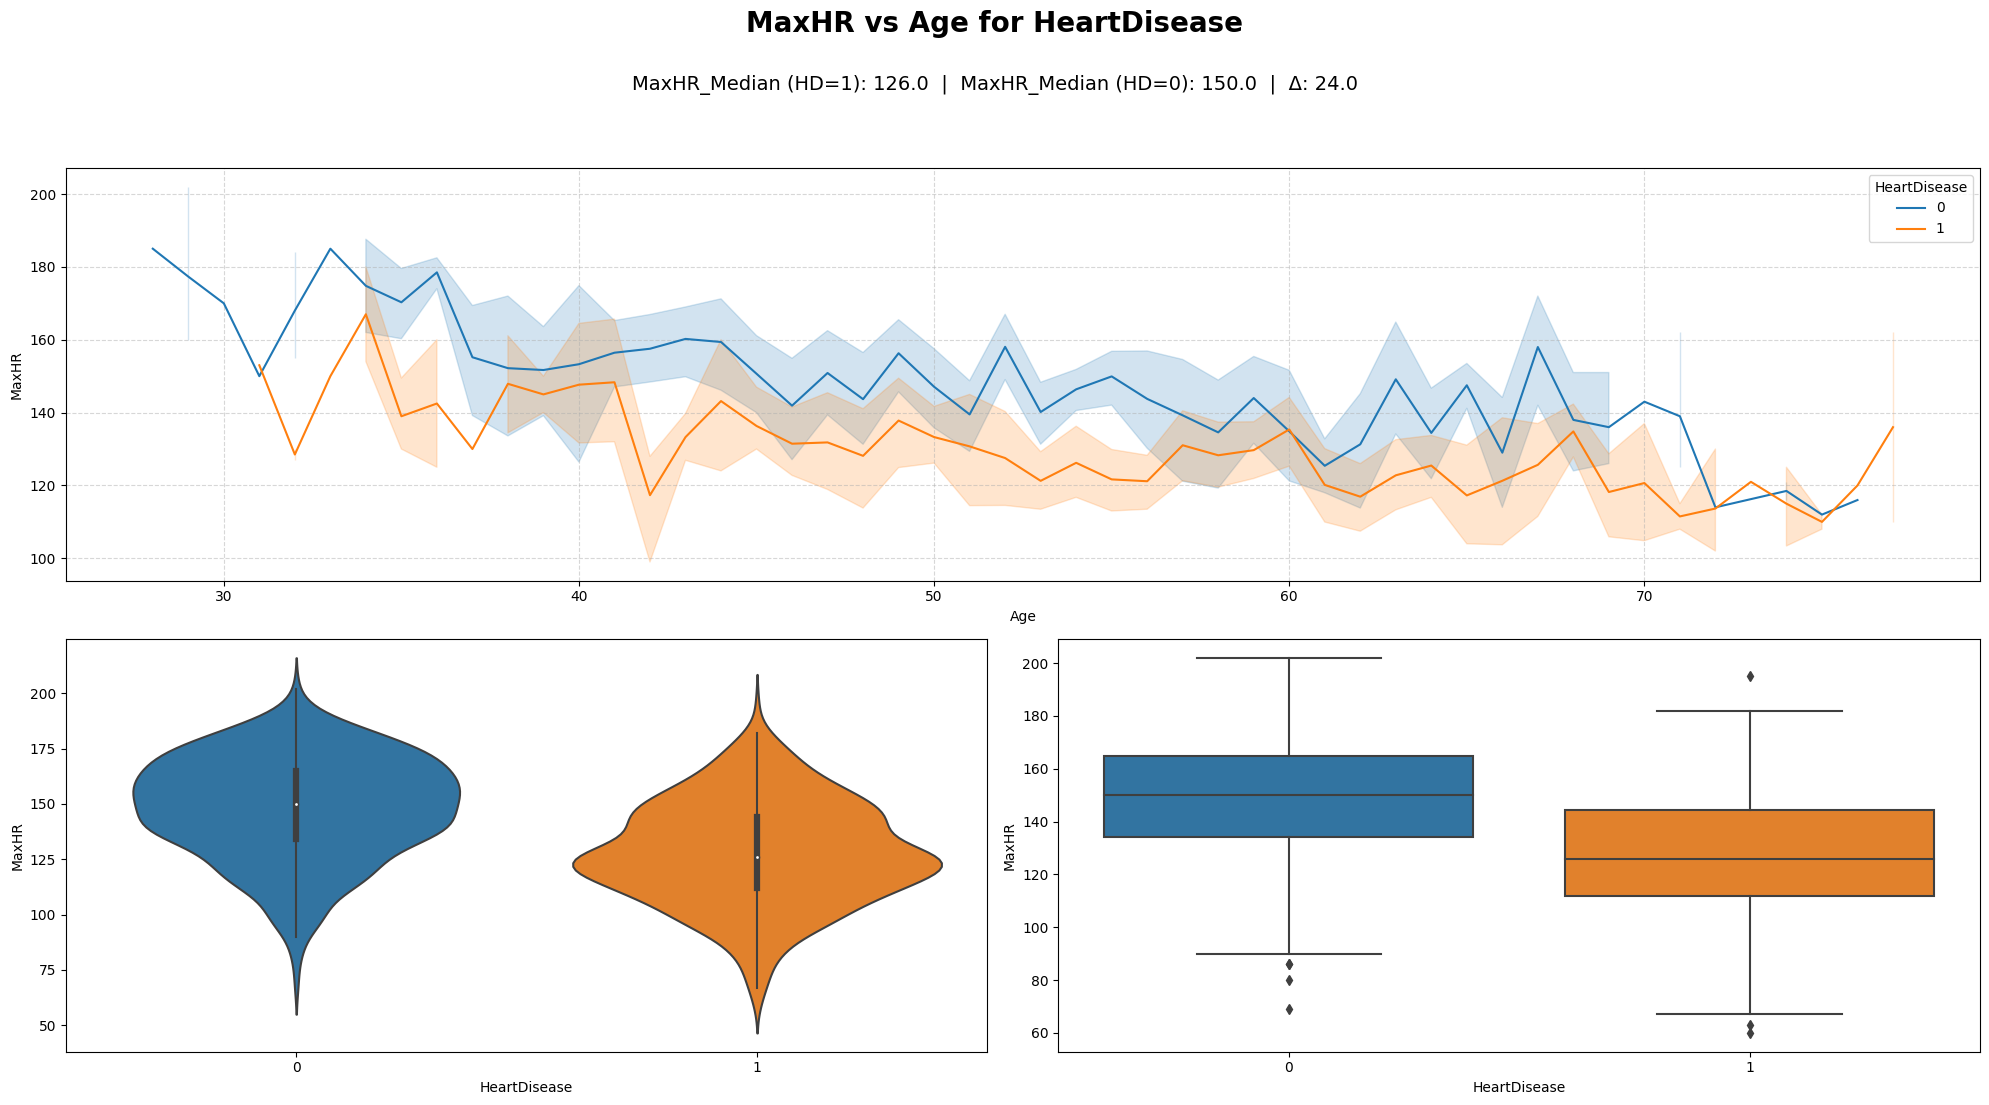




----- Oldpeak ----- 


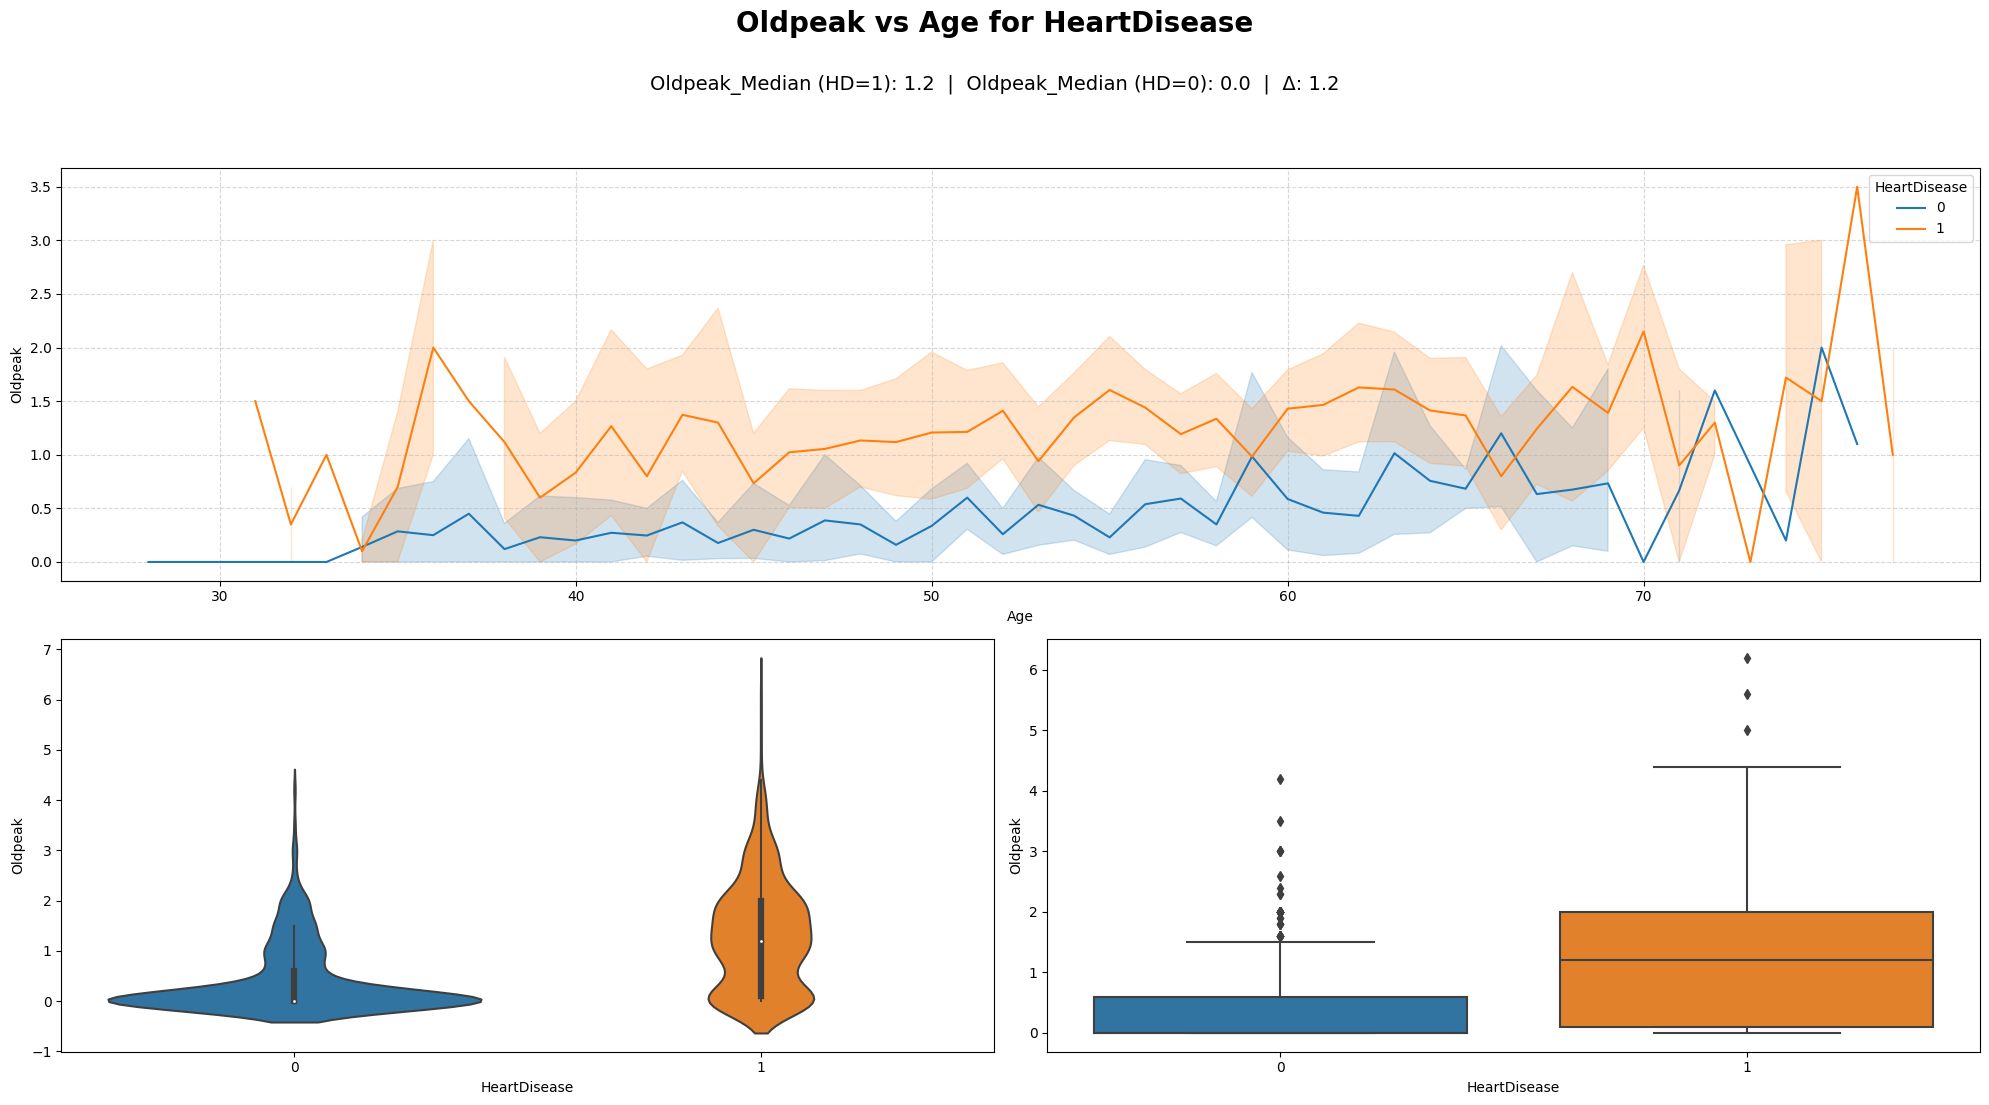

In [17]:
con_num_col = [c for c in col_num if c not in ['Age', 'HeartDisease']]
for i in con_num_col:
    print(f"\n----- {i} ----- ")
    continuous_plot(df,i)
    print('\n')

#### Insights — Continuous Features

From the **trivariate (Line plots)** and **bivariate (Violin & Box plots)** analyses, several age-related trends and group-level differences emerge:

- **Age Trends (Line Plot):**
  - Across most variables, separation between HeartDisease = 1 and HeartDisease = 0 becomes more noticeable in **middle to older age groups**.  
  - Features such as *MaxHR* and *Oldpeak* show sharper age-related shifts, highlighting their strong association with disease risk.

- **Distribution Differences (Violin & Box Plots):**
  - Clear **median differences (Δ)** distinguish the two groups for some variables.  
  - The **spread (IQR)** also points to greater variability among HeartDisease patients, particularly for *Cholesterol*.

---

### Variable-wise Observations

- **RestingBP:**  
  - Median values are slightly higher in HeartDisease patients (132 vs. 130).  
  - The overlap is substantial, suggesting it offers limited predictive separation.  

- **Cholesterol:**  
  - Median is higher for HeartDisease patients (247 vs. 233.5).  
  - The distribution is wider in the diseased group, giving it moderate predictive strength.  

- **FastingBS:**  
  - No median difference (both groups at 0).  
  - Provides no discriminatory power in this dataset.  

- **MaxHR:**  
  - Strong separation with noticeably lower median values in HeartDisease patients (126 vs. 150).  
  - This negative correlation with risk makes it a highly predictive feature.  

- **Oldpeak:**  
  - One of the clearest discriminators, with median values substantially higher in HeartDisease patients (1.2 vs. 0).  
  - Consistently separates the groups, making it one of the strongest predictors.  

---

 **Key Takeaways:**  
- **MaxHR** and **Oldpeak** are the most powerful continuous predictors, showing clear and clinically consistent separation.  
- **Cholesterol** adds moderate predictive value but overlaps across groups.  
- **RestingBP** provides marginal information, while **FastingBS** does not contribute.  
- These findings reinforce known cardiovascular risk factors: reduced exercise capacity (*low MaxHR*) and higher ST depression (*Oldpeak*) are strong indicators of disease.  


## 4.4 Univariate (`Distribution_plot`)

For each continuous numerical variable, we plot its **distribution (histogram + KDE)**.  
This helps us examine the underlying distribution shape, skewness, and possible transformations (e.g., log-scaling).

- `ncol = 2` → plots arranged in 2 columns.  
- `nrow` is automatically computed so that all variables fit across multiple rows.  
- **Extra subplot issue:**  
  - If the number of features `n` is **even** (e.g., 6), all subplots get filled → no issue.  
  - If `n` is **odd** (e.g., 5), `plt.subplots` still creates 6 axes → we must **turn off the unused one**.  
  - This is handled by `for j in range(i+1, len(ax))` where `i` is the last index used inside the loop.


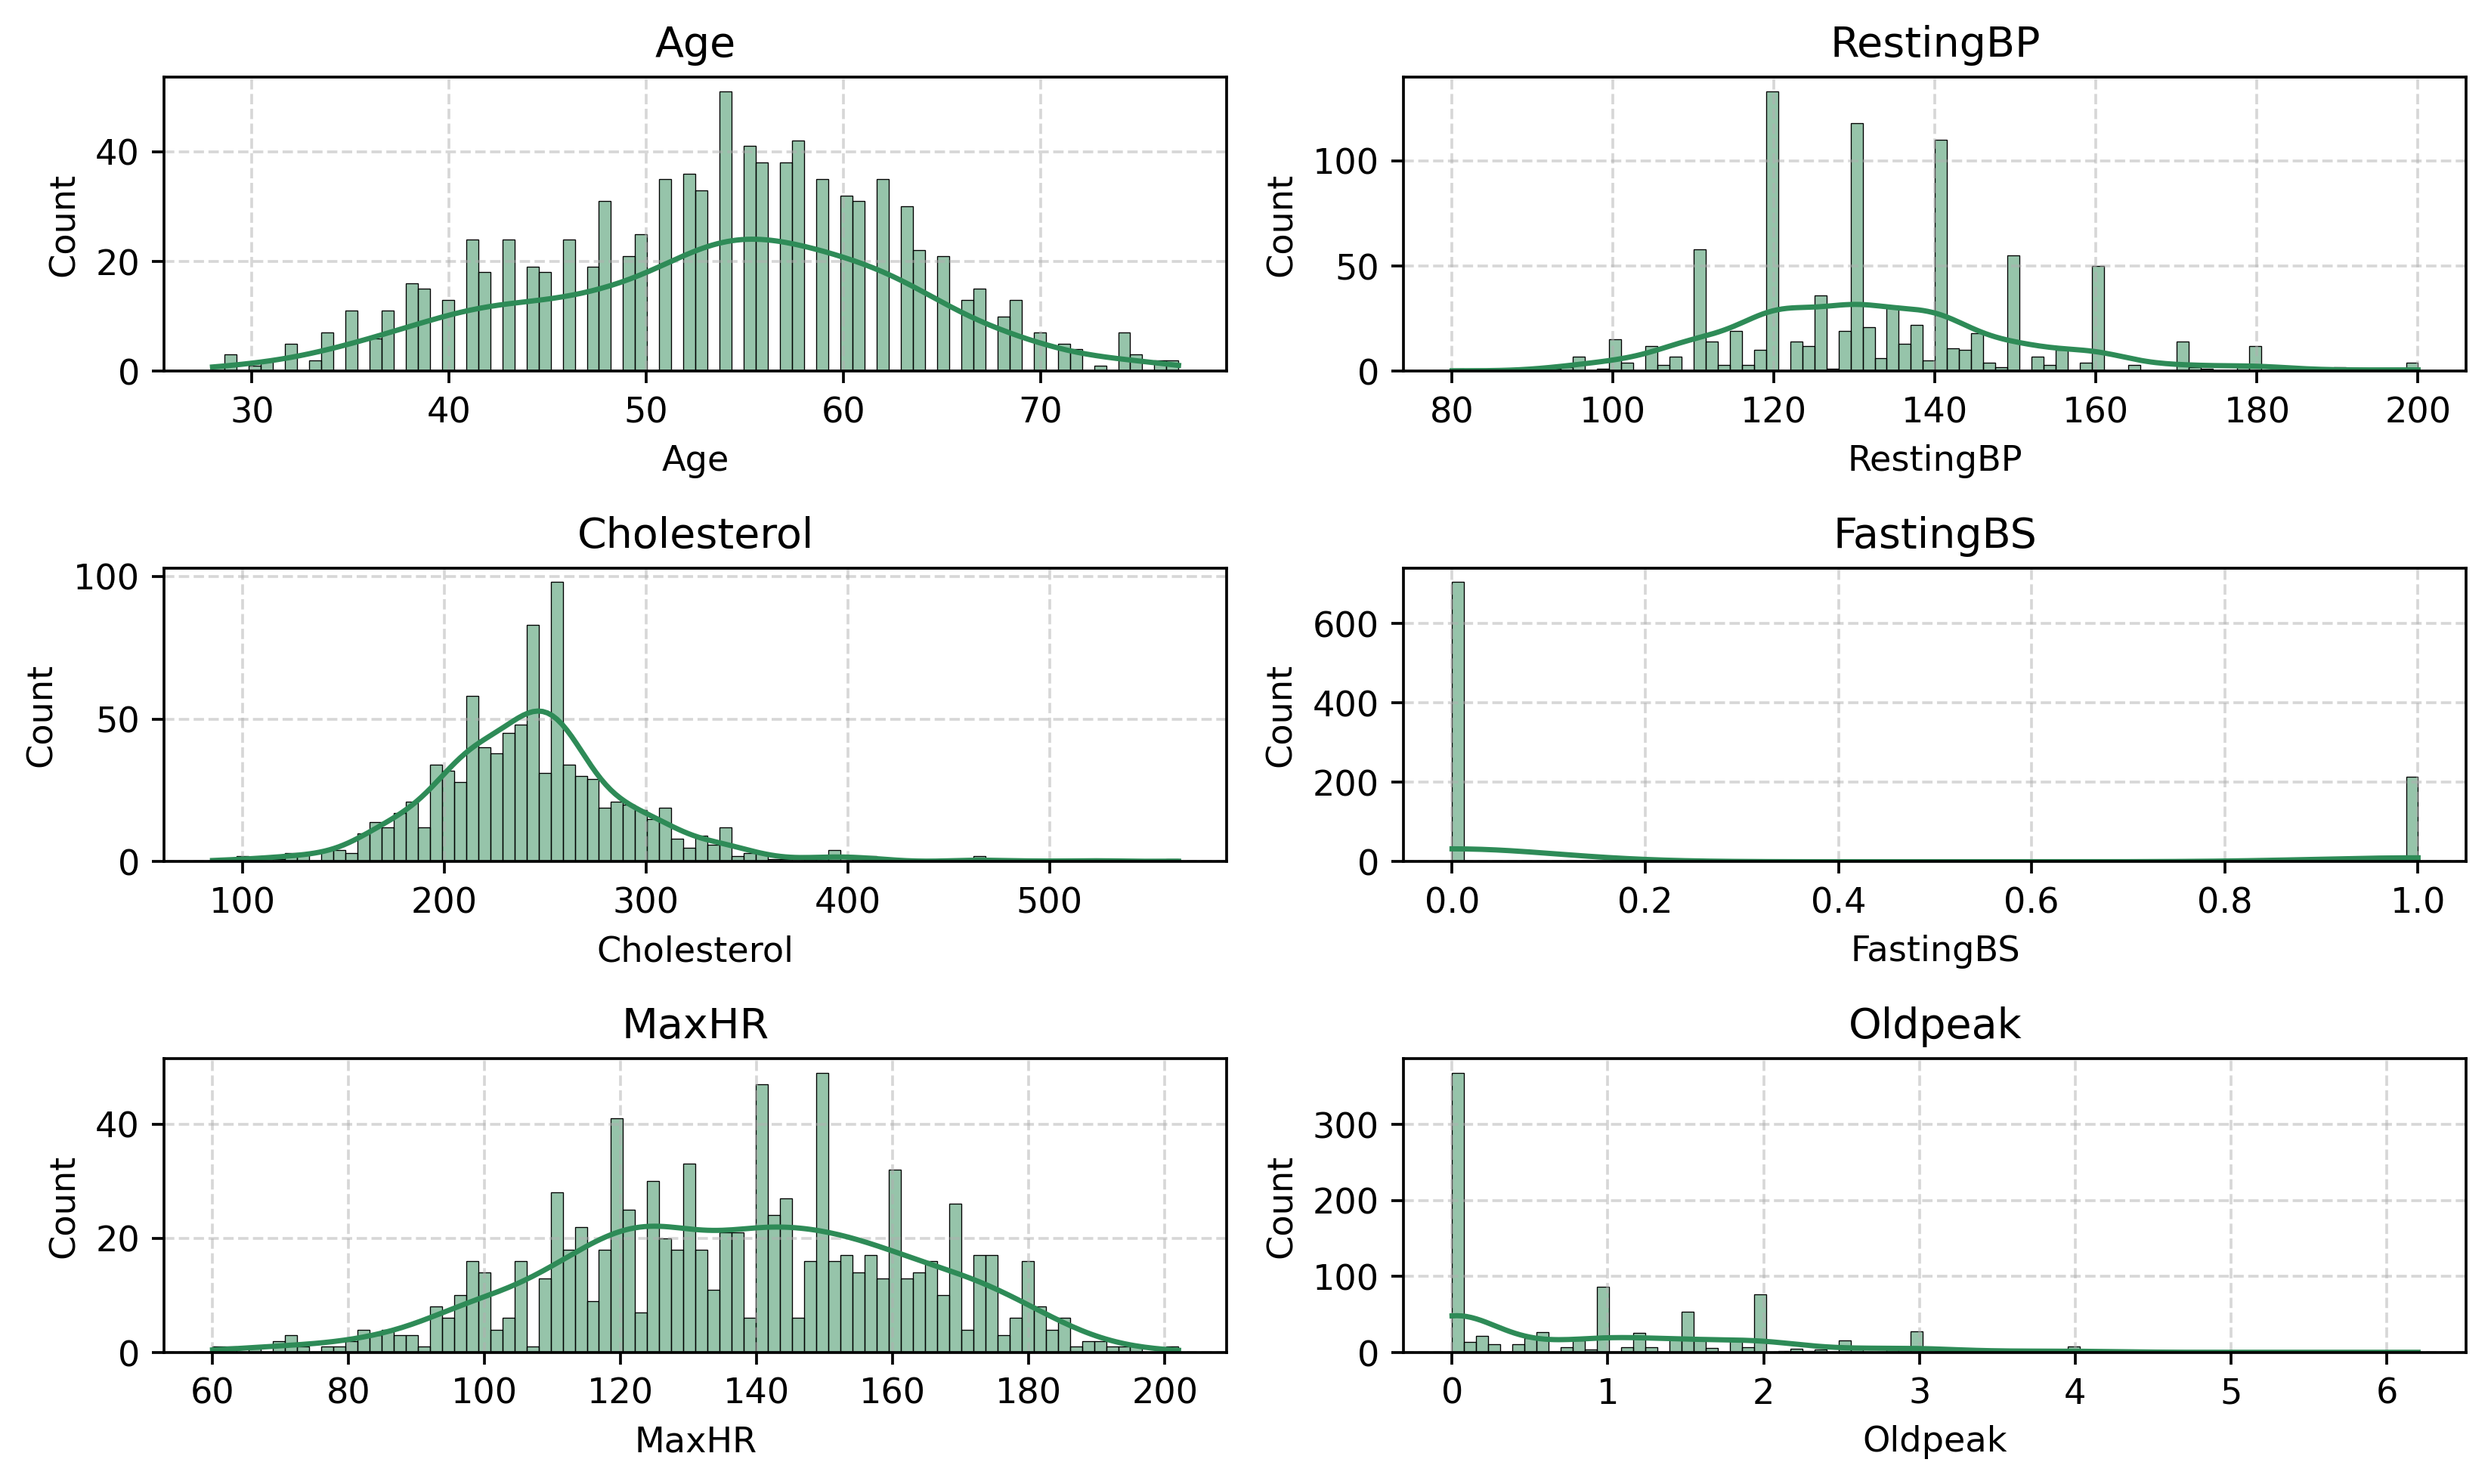

In [18]:
# Univariate Distribution Plots (Continuous Variables)

# Take all numeric columns except target
num_col2 = [c for c in col_num if c not in ['HeartDisease']]
n = len(num_col2)       # number of features to plot
ncol = 2                # fixed 2 columns layout
nrow = (n+1)//ncol      # rows needed

# Create subplots
fig, ax = plt.subplots(nrow, ncol, figsize=(10,nrow*2), dpi=333)
ax=ax.flatten()         # flatten 2D axes into 1D for easy iteration

# Plot histogram + KDE for each variable
for i,c in enumerate(num_col2):

    sns.histplot(df[c], bins=80, kde=True, color='seagreen', ax=ax[i])
    ax[i].set_title(c)

# Turn off unused subplot(s), if any (when n is odd)
for j in range(i+1,len(ax)):
    ax[j].axis('off')

# Add light gridlines for readability
for g in ax[:n]:
    g.grid(True, which='both', axis='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Note:
- Example with `n = 5`:  
  - Axes created = 6 (`0,1,2,3,4,5`)  
  - Loop ends with `i = 4`  
  - Extra axis at position `5` is turned off (`range(5,6)`).  

- Example with `n = 6`:  
  - Axes created = 6 (`0,1,2,3,4,5`)  
  - Loop ends with `i = 5`  
  - No extra axis → nothing is turned off.  

This ensures the grid layout stays neat for both even and odd numbers of features.


In [19]:
# Example transformation: Oldpeak shows positive skew → apply log1p
df['Oldpeak_log1p'] = np.log1p(df['Oldpeak'])

# **5. Feature Engineering**
- 5.1 Domain-Informed Features – Features derived from clinical knowledge or subject expertise
- 5.2 Encoding Categorical Variables – Converting categories into numeric form (ordinal, one-hot, etc.)
- 5.3 Feature Interactions & Pairing – Creating interaction terms and combined risk indicators
- 5.4 Feature Transformations – Applying mathematical transforms (e.g., log1p) for skew reduction 

## 5.1 Domain-Informed Features  

In this step, we create new features derived from **clinical knowledge** and domain expertise.  
These features capture risk factors and medical insights that may not be directly represented in the raw data.  
These engineered features aim to **incorporate medical reasoning** into the dataset, improving the model’s ability to detect patterns that align with clinical practice.


In [20]:
#1. Age Group (AgeGroup): Cardiovascular risk increases with age. Grouping helps capture nonlinear effects.
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,35,45,55,65,100],labels=['<35','35-44','45-54','55-64','65+'])

#2. Cholesterol Features: Cholesterol above 240 mg/dL is considered high risk for heart disease.
df['CholesterolFlag'] = pd.cut(df['Cholesterol'],bins=[0,200,240,1000],labels=['Normal','Borderline','High'])
df['IsHighCholesterol'] = (df['Cholesterol']>240)

#3. Resting Blood Pressure Category (BP_Category): Elevated resting BP is an indicator of hypertension, a strong heart disease risk factor.
df['BP_Category'] = pd.cut(df['RestingBP'], bins=[0,120,130,140,160,300], labels=['Normal', 'Elevated', 'Stage 1', 'Stage 2', 'Severe'])

#4. MaxHR / Target Heart Rate: If a person cannot reach 85% of their predicted max HR, it may indicate heart inefficiency.
df['TargetHR'] = (220 - df['Age']) # theoretical max heart rate
df['HR_Percent'] = df['MaxHR'] / df['TargetHR']
df['Below85pctMaxHR'] = (df['HR_Percent'] < 0.85)

#5. Angina + Low MaxHR Interaction: Having exercise-induced angina and low HR % indicates poor heart performance under stress.
df['Angina_LowHR'] = ((df['ExerciseAngina'] == 'Y') & (df['HR_Percent'] < 0.85)).astype(np.int8)

#6. ST Depression + Slope: ST depression >2 mm and downsloping ST segment are strong ECG indicators of ischemia.
df['HighST_Depression'] = (df['Oldpeak'] > 2).astype(np.int8)
df['Bad_ST_Combo'] = ((df['Oldpeak'] > 2) & (df['ST_Slope'] == 'Down')).astype(np.int8)

#7. Chest Pain Risk Mapping: Maps chest pain types into ordinal risk levels (TA → ASY).
chest_pain_map = {'TA': 0,'ATA': 1,'NAP': 2,'ASY': 3}
df['ChestPainRisk'] = df['ChestPainType'].map(chest_pain_map).astype(np.int8)

#8. Sex + Age Based Risk Flags: Early heart disease is more common in younger males and older females.
df.loc[:,'YoungMaleHighRisk'] = ((df['Sex'] == 'M') & (df['Age'] < 55)).astype(np.int8)
df.loc[:,'OlderFemaleRisk'] = ((df['Sex'] == 'F') & (df['Age'] > 65)).astype(np.int8)

#9. Composite Risk Scores: Aggregates multiple conditions (high BP, cholesterol, fasting sugar, Oldpeak, angina) into simple risk indices.
df['RiskScore'] = ((df['RestingBP'] > 140).astype(np.int8) +(df['Cholesterol'] > 240).astype(np.int8) +(df['FastingBS'] == 1).astype(np.int8) +(df['Oldpeak'] > 2).astype(np.int8) +(df['ExerciseAngina'] == 'Y').astype(np.int8)).astype(np.int8)
df['RiskScore_coded']=((df['RestingBP'] > 140).astype(np.int8))*1 +((df['Cholesterol'] > 240).astype(np.int8))*10 +((df['FastingBS'] == 1).astype(np.int8))*100 +((df['Oldpeak'] > 2).astype(np.int8))*1000 +((df['ExerciseAngina'] == 'Y').astype(np.int8))*10000


In [21]:
# Domain Features
domain_features=['AgeGroup','CholesterolFlag','IsHighCholesterol','BP_Category','TargetHR','HR_Percent','Below85pctMaxHR','Angina_LowHR','HighST_Depression','Bad_ST_Combo','ChestPainRisk','YoungMaleHighRisk','OlderFemaleRisk','RiskScore','RiskScore_coded']

## 5.2 Encoding Categorical Variables
To make categorical features suitable for machine learning models, we apply both **One-Hot Encoding (OHE)** and **Ordinal Encoding**:  


#### **Step 1: Inspect Categorical Columns**  
  - Print categorical (`object`) columns and their unique values for reference. 

In [22]:
# Inspect categorical columns and their unique values
for i in col_obj:
    print(i,df[i].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


#### **Step 2: One-Hot Encoding (OHE)**  
  - Applied to nominal variables (e.g., `Sex`, `RestingECG`, `ST_Slope`).  
  - Creates binary indicator columns without implying any order.  
  - `drop_first=False` ensures all categories are retained (no information loss).  

In [23]:
# Select nominal categorical columns (exclude 'ChestPainType' which is ordinal)
ohe_col = [col for col in col_obj if col != 'ChestPainType'] 
# Apply OHE and convert to int8 for memory efficiency
df_OHE = pd.get_dummies(df[ohe_col], drop_first=False).astype(np.int8)
# Merge the OHE features back to the dataframe
df = pd.concat([df,df_OHE],axis=1)

#### **Step 3: Ordinal Encoding**  
  - Applied to `category` dtype columns (e.g., `ChestPainType`).  
  - Converts categories into integer codes while preserving their **intrinsic order**.  
  - Encoded features are stored with the `_encoded_cat` suffix.  


In [24]:
# Identify categorical columns with dtype 'category' (ordered categories)
category_col = [c for c in df.columns if df[c].dtype=='category']
# Convert categories to integer codes and store in new columns
for c in category_col:
    name=f'{c}_encoded_cat'
    df[name] = df[c].cat.codes.astype(np.int8)
    
# Collect list of encoded categorical columns
encoded_cat_cols = [col for col in df.columns if col.endswith("_encoded_cat")]

## 5.3 Feature Interactions & Pairing  

To capture potential relationships between categorical features, we generate interaction features by pairing them.  
- All categorical (`object`/`category`) columns are considered, along with two important features: `RiskScore_coded` and `RiskScore`.  
- Each pair of features is combined into a single feature (string concatenation), then converted into category codes.  
- These new interaction features are added back to the dataset.  


In [25]:
# Collect categorical features (object and category dtypes)
comb_features = [c for c in df.columns if df[c].dtype in ['object','category']]

# Add RiskScore features manually since they are categorical in nature
comb_features.extend(['RiskScore_coded','RiskScore']) 
new_features={} 
pairs=[] 

# Loop through all combinations of categorical features
for i,c1 in enumerate(comb_features):
    for j,c2 in enumerate(comb_features):
        n = f'{c1}_{c2}' 
        # Concatenate values of c1 and c2, convert to category codes, and store as int8
        new_features[n] = df[[c1,c2]].astype(str).agg('_'.join, axis=1).astype('category').cat.codes.astype(np.int8)
        pairs.append(n) 

# Add all new interaction features back to the main dataframe
df = pd.concat([df,pd.DataFrame(new_features)],axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Columns: 164 entries, Age to RiskScore_RiskScore
dtypes: bool(2), category(4), float64(4), int16(1), int64(6), int8(142), object(5)
memory usage: 243.1+ KB


#### 163 Features !!

# **6. Train \ Valid \ Test Split - `70 | 20 | 10`**

The `train_test_split` function is used in two stages:  
1. First, 10% of the data is separated as the test set.  
2. Then, the remaining 90% is split into training (70%) and validation (20%).  

Stratification ensures class balance is preserved across all splits.  


In [27]:
from sklearn.model_selection import train_test_split

target = 'HeartDisease' # Define target variable

# Select numeric features only, excluding target
X = df.select_dtypes(include=['float64','int64','int8']).drop(target,axis=1).copy()
y = df[target].copy()

# Step 1: Split off 10% as test set; Step 2: Split remaining 90% into 70% train and 20% validation
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=2/9,random_state=42, stratify=y_temp) # 2/9 ≈ 0.222 ensures valid set is 20% of total

# **7. Feature Importance**

Understanding **which features contribute the most** to predicting heart disease helps improve model interpretability and guides feature selection.  
Several approaches are used here to calculate and evaluate feature importance:


## **7.1 Feature Importance Calculation**

### **7.1.1 Random Forest for Feature Importance**
- Train a `RandomForestClassifier` with class weights balanced to handle class imbalance.  
- Extract top 50 features based on importance scores.  
- Remove **highly correlated features** (`corr > 0.75`) to avoid redundancy.  
- Plot the remaining most important features.

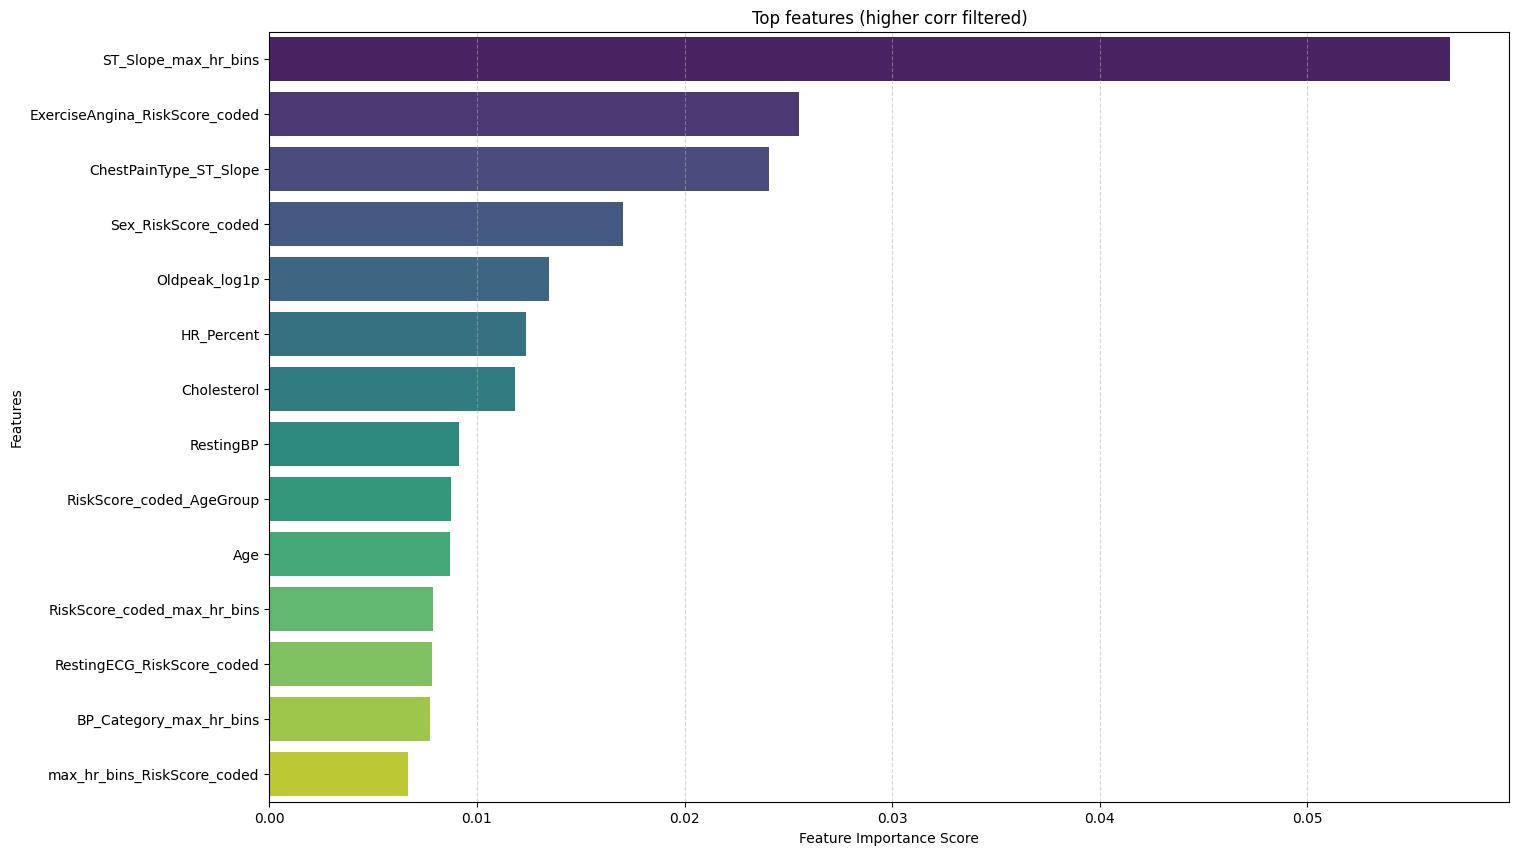

In [28]:
# --- 7.1.1 Random Forest Feature Importance ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train,y_train)
# Map top 50 important features
imp_map = (pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(50).to_dict())

# Remove highly correlated features (corr > 0.75)
corr_matrix = X[imp_map.keys()].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
high_corr = [c for c in upper.columns if any(upper[c]>0.75)]
# Keep only non-correlated important features
final_importance = (pd.Series(imp_map).drop(high_corr,errors='ignore').to_dict()) 
final_features = list(final_importance.keys())

# Plot top features
plt.figure(figsize=(16,10))
sns.barplot(x=list(final_importance.values()), y=final_features, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top features (higher corr filtered)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

### **7.1.2 Permutation Importance**
- Use `permutation_importance` to measure feature contributions by shuffling feature values.  
- AUC (`roc_auc`) is used as the scoring metric.  
- Features are ranked both by mean importance and by a stability-adjusted score (`mean - std`).


In [29]:
# --- 7.1.2 Permutation Importance ---
from sklearn.inspection import permutation_importance

r = permutation_importance(rf, X_valid, y_valid, n_repeats=10, random_state=42, scoring='roc_auc')
perm_df = pd.DataFrame({'feature':X_train.columns, 'importances_mean':r.importances_mean, 'importances_std':r.importances_std,'score':(r.importances_mean-r.importances_std)}).sort_values(by='importances_mean', ascending=False)

# Sorted lists
perm_feature = perm_df.feature.tolist() # by importance
perm_df_score=perm_df.loc[perm_df['score']>0][['feature','importances_mean']].reset_index(drop=True) # by score

### **7.1.3 Random Forest + Permutation Merge**
- Identify **common features** between random forest and permutation importance.  
- Merge top 10 random forest features with top 3 common features from permutation results.


In [30]:
# --- 7.1.3 Combine RandomForest + Permutation Features ---
common_f = np.intersect1d(perm_df_score['feature'],final_features)
perm_merge_list = list(dict.fromkeys(list(final_features[:10])+list(common_f[:3])))

### **7.1.4 Recursive Feature Elimination (RFE)**
- Use **Linear Regression** with RFE to select the top 20 features.  
- RFE recursively removes least important features until desired number is reached.


In [31]:
# --- 7.1.4 RFE with Linear Regression ---
estimator = LinearRegression()
rfe = RFE(estimator,n_features_to_select=20)
rfe.fit(X_temp,y_temp)
selected_rfe_features = X_temp.columns[rfe.support_].tolist()

## **7.2 Feature Importance Evaluation**
- Define a helper function `cvs()` to run **10-fold cross-validation** with selected features.  
- Compare feature subsets:
  - Top 10 from random forest  
  - Top 15 and top 30 from permutation importance  
  - Top 10 permutation (stability adjusted)  
  - Top 20 from RFE  
  - Combination of random forest and permutation-selected features  

The performance is reported using **mean ROC-AUC score**.

In [32]:
# --- 7.2 Feature Importance Evaluation ---
def cvs(sel_f_,i):
    """Cross-validation with top 'i' selected features"""
    x1 = X_train[sel_f_[:i]]
    y1 = y_train
    clf = RandomForestClassifier(n_estimators=100,random_state=42)
    scores =  cross_val_score(clf, x1, y1, cv=10, scoring='roc_auc')
    return f"Mean AUC (Top {i}):", scores.mean()

# Compare feature subsets
print(f"final_features 10: {cvs(list(final_features),10)}")
print(f"perm top 15: {cvs(perm_feature,15)}")
print("perm top 30:",cvs(perm_feature,30))
print("permutation_score_sorted:",cvs(perm_df_score['feature'],10))
print(f"RFE top 20: {cvs(selected_rfe_features,20)}")
print("final_features top10 + final_features intsct permutation:",cvs(perm_merge_list,len(perm_merge_list)))

final_features 10: ('Mean AUC (Top 10):', 0.904269978106185)
perm top 15: ('Mean AUC (Top 15):', 0.8889501231527094)
perm top 30: ('Mean AUC (Top 30):', 0.8899760536398468)
permutation_score_sorted: ('Mean AUC (Top 10):', 0.8798830049261083)
RFE top 20: ('Mean AUC (Top 20):', 0.8833148604269294)
final_features top10 + final_features intsct permutation: ('Mean AUC (Top 11):', 0.9020477558839628)


In [33]:
# Display Final Selected Features
final_features

['ST_Slope_max_hr_bins',
 'ExerciseAngina_RiskScore_coded',
 'ChestPainType_ST_Slope',
 'Sex_RiskScore_coded',
 'Oldpeak_log1p',
 'HR_Percent',
 'Cholesterol',
 'RestingBP',
 'RiskScore_coded_AgeGroup',
 'Age',
 'RiskScore_coded_max_hr_bins',
 'RestingECG_RiskScore_coded',
 'BP_Category_max_hr_bins',
 'max_hr_bins_RiskScore_coded']

# **8. Pre-Model Evaluation (Baseline Modeling)**
Before moving into advanced hyperparameter tuning, we perform **baseline modeling** to understand how simple models perform with our selected features.  


## **8.1 Preparing Pipelines for Baseline Models**
- **Continuous Features** → Standard Scaled (`StandardScaler`)  
- **Categorical-like Features** → Passed through as-is (`passthrough`)  
- Built pipelines for 5 baseline classifiers:
  - Random Forest (shallow tuning, class balancing, OOB enabled)
  - Logistic Regression
  - Decision Tree (shallow depth)
  - Logistic Regression with Cross-Validation
  - XGBoost Classifier (minimal tuning)

In [34]:
# -----------------------------
# 8.1 Preparing Pipelines
# -----------------------------

# Define continuous and categorical-like features
continuous = ['Oldpeak_log1p', 'HR_Percent', 'Cholesterol', 'RestingBP', 'Age'] ; categorical_like = ['ST_Slope_max_hr_bins', 'ExerciseAngina_RiskScore_coded', 'Sex_RiskScore_coded', 'RiskScore_coded_AgeGroup','ChestPainType_ST_Slope']

# Combine features for modeling
features = continuous + categorical_like 
target = 'HeartDisease'

# Column transformer:
# - StandardScaler applied to continuous variables
# - categorical-like features passed through
preprocessor = ColumnTransformer(transformers=[('scale',StandardScaler(),continuous)], remainder='passthrough')

# Define baseline model pipelines
pipeline_RFC = Pipeline([('preprocess', preprocessor),('classifier', RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced',oob_score=True,bootstrap=True, random_state=42))])
pipeline_LR = Pipeline([('preprocess', preprocessor),('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))])
pipeline_DTC = Pipeline([('preprocess', preprocessor),('classifier', DecisionTreeClassifier(max_depth=2,random_state=42))])
pipeline_LRCV = Pipeline([('preprocess', preprocessor),('classifier', LogisticRegressionCV(cv=5, solver='liblinear', max_iter=1000))])
pipeline_XGB = Pipeline([('preprocess', preprocessor),('classifier', XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Store all pipelines in a dictionary for iteration
pipelines = {'RandomForest': pipeline_RFC,'LogisticRegression': pipeline_LR,'DecisionTree': pipeline_DTC,'LogisticCV': pipeline_LRCV,'XGBClassifier':pipeline_XGB}

# Update data splits to include only final selected features
X_temp, X_test = X_temp[features], X_test[features]
X_train, X_valid = X_train[features], X_valid[features]


## **8.2 Evaluating Base Models**
- Defined a helper function `metric_cal()` to compute **Accuracy** and **ROC-AUC** for both **train** and **validation** sets.  
- Trained each model and stored results in a comparative DataFrame.  
- Displayed both summary metrics and classification reports for Random Forest and XGBoost (best performing candidates).

In [35]:
# -----------------------------
# 8.2 Evaluating Base Models
# -----------------------------

# Function to calculate metrics (Accuracy + ROC-AUC)
def metric_cal(model, xxtrain, xxvalid, yytrain, yyvalid):
    
    # Predictions - train
    y_pred_train = model.predict(xxtrain)
    y_scores_train = model.predict_proba(xxtrain)[:,1]
    
    # Predictions - valid
    y_pred_valid = model.predict(xxvalid)
    y_scores_valid = model.predict_proba(xxvalid)[:, 1]

    # Train metrics
    acc_train = accuracy_score(yytrain, y_pred_train)
    auc_train = roc_auc_score(yytrain, y_pred_train) # (ROC-AUC on predicted labels)
     
    # Validation metrics
    acc_valid = accuracy_score(yyvalid, y_pred_valid)
    auc_valid = roc_auc_score(yyvalid, y_scores_valid) # (ROC-AUC on probabilities)

    return acc_train, acc_valid, auc_train, auc_valid, y_pred_valid

In [36]:
results = []  # Store performance of each model
classification_report_dict = {}  # Store classification reports

# Loop through all pipelines
for name, model in pipelines.items():
    #Fit and evaluate
    model.fit(X_train,y_train)

    # Evaluate metrics
    acc_train, acc_valid, auc_train, auc_valid, y_pred_valid = metric_cal(model, X_train, X_valid, y_train, y_valid)

    # Append results for summary table
    results.append({'Model': name, 'Train_Accuracy': round(acc_train, 3), 'Train_ROC_AUC': round(auc_train, 3),
                                   'Val_Accuracy': round(acc_valid, 3), 'Val_ROC_AUC': round(auc_valid, 3)})

    # Generate classification report for validation set
    nn = pd.DataFrame(classification_report(y_valid, y_pred_valid,output_dict=True)).transpose(); nn.index.name = name
    classification_report_dict[f'{name}_Valid'] = nn
    
# Display summary metrics
display(pd.DataFrame(results))

,Model,Train_Accuracy,Train_ROC_AUC,Val_Accuracy,Val_ROC_AUC
0,RandomForest,0.874,0.871,0.918,0.971
1,LogisticRegression,0.836,0.833,0.902,0.954
2,DecisionTree,0.833,0.834,0.913,0.929
3,LogisticCV,0.840,0.836,0.908,0.953
4,XGBClassifier,0.989,0.989,0.918,0.969


In [37]:
# Display detailed classification reports for selected models
display(classification_report_dict['RandomForest_Valid'])
display(classification_report_dict['XGBClassifier_Valid'])

,precision,recall,f1-score,support
RandomForest,,,,
0,0.894118,0.926829,0.910180,82.000000
1,0.939394,0.911765,0.925373,102.000000
accuracy,0.918478,0.918478,0.918478,0.918478
macro avg,0.916756,0.919297,0.917776,184.000000
weighted avg,0.919216,0.918478,0.918602,184.000000


,precision,recall,f1-score,support
XGBClassifier,,,,
0,0.894118,0.926829,0.910180,82.000000
1,0.939394,0.911765,0.925373,102.000000
accuracy,0.918478,0.918478,0.918478,0.918478
macro avg,0.916756,0.919297,0.917776,184.000000
weighted avg,0.919216,0.918478,0.918602,184.000000


#### **Baseline Model Analysis**

We started by evaluating multiple classifiers as baseline models, including **Logistic Regression, LogisticCV, Decision Tree, Random Forest, and XGBoost**.  

##### **Logistic Regression / LogisticCV**
- Achieved good performance with validation ROC AUC ≈ 0.95.  
- Being linear models, they provided interpretability but struggled to capture complex non-linear relationships.  
- Overall, they were reliable baselines but not the strongest performers.  

##### **Decision Tree**
- Showed moderate results (Val ROC AUC = 0.929).  
- Although simple and interpretable, the model was unstable and less robust compared to ensemble methods.  

##### **Random Forest**
- Delivered **Val Accuracy = 0.918** and **Val ROC AUC = 0.971**.  
- Balanced performance across both classes, with precision, recall, and F1-scores showing no major bias.  
- Demonstrated robustness and strong generalization, making it a strong candidate.  

##### **XGBoost (XGBClassifier)**
- Validation metrics were nearly identical to Random Forest (**Val Accuracy = 0.918, ROC AUC = 0.969**).  
- However, training accuracy and ROC AUC (~0.989) were much higher, highlighting its capacity to learn complex feature interactions.  
- Importantly, it did not show severe overfitting since validation performance remained very strong.  

---

#### **Why Random Forest and XGBoost were chosen**
- Both significantly outperformed the simpler baselines.  
- Achieved **ROC AUC > 0.96**, showing strong ability to separate classes.  
- Delivered **balanced classification** (precision, recall, F1) across both classes.  
- Logistic Regression and Decision Tree, while useful references, were clearly weaker in predictive performance.  

**Hence, Random Forest and XGBoost were shortlisted for further hyperparameter tuning.**


# **9. ML Modeling**

This section focuses on **hyperparameter tuning and final model selection**.

## **9.1 Hypertuning with Optuna**
- We scale train/valid data before tuning (using the same preprocessing pipeline).  
- Optuna is used to optimize:
  - **RandomForestClassifier** (parameters like `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `bootstrap`).  
  - **XGBClassifier** (parameters like `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `reg_alpha`, `reg_lambda`).  
- Objective function returns **ROC-AUC score** for each trial.  
- Accuracy (`acc`) is also logged for reference.  
- Best parameters, accuracy, and ROC-AUC are displayed after study completion.  


In [38]:
# -----------------------------
# 9.1 Hypertuning (Optuna)
# -----------------------------

# Scale the train and validation data before Optuna optimization
X_train_scaled = preprocessor.fit_transform(X_train)
X_valid_scaled = preprocessor.transform(X_valid)

# Silence Optuna's trial-level logs (keeps progress bar clean)
optuna.logging.set_verbosity(optuna.logging.WARNING)

### 9.1.1 RandomForestClassifier

In [39]:
# -----------------------------
# 9.1.1 RandomForestClassifier
# -----------------------------
def objective(trial):
    """Objective function for RandomForest hyperparameter optimization."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_train)

    # Predictions and probability scores on validation set
    preds = model.predict(X_valid_scaled)
    proba = model.predict_proba(X_valid_scaled)[:, 1]

    # Metrics: Accuracy and ROC-AUC
    acc = accuracy_score(preds,y_valid)
    rocc = roc_auc_score(y_valid, proba)

    # Log accuracy as a trial attribute
    trial.set_user_attr('acc',acc)
    
    return rocc
 
# Run Optuna for RandomForest
sampler = optuna.samplers.TPESampler(seed=111) # reproducible results
study_rf = optuna.create_study(direction = 'maximize' ,sampler=sampler)
study_rf.optimize(objective, n_trials=111, show_progress_bar=True) # i ran over thousand trials but 111th trial gave best score

# Best trial results
print("Best ROC AUC:", study_rf.best_value)
print("Best Accuracy:", study_rf.best_trial.user_attrs['acc'])
print("Best parameters:", study_rf.best_params)

  0%|          | 0/111 [00:00<?, ?it/s]

Best ROC AUC: 0.980153036824486
Best Accuracy: 0.9293478260869565
Best parameters: {'n_estimators': 64, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': False}


### 9.1.2 XGBClassifier

In [40]:
# -----------------------------
# 9.1.2 XGBClassifier
# -----------------------------
import optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',     # fast histogram-based algorithm
        #'device': 'cuda',          # GPU usage
        #'n_jobs': -1,
        'eval_metric': 'logloss',
        'random_state': 42,
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=5),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0)
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train,
              eval_set=[(X_valid_scaled, y_valid)],
              verbose=False)

    preds = model.predict(X_valid_scaled)
    proba = model.predict_proba(X_valid_scaled)[:, 1]

    acc = accuracy_score(preds,y_valid)
    rocc = roc_auc_score(y_valid, proba)
    trial.set_user_attr('acc',acc)
    
    return rocc

# Run Optuna for XGBClassifier
sampler = optuna.samplers.TPESampler(seed=123) # reproducible results
study_xgb = optuna.create_study(direction = 'maximize' ,sampler=sampler)
study_xgb.optimize(objective, n_trials=1660, show_progress_bar=True) # i ran over two thousand trials but 1658th trial gave best score

# Best trial results
print("Best ROC AUC:", study_xgb.best_value)
print("Best Accuracy:", study_xgb.best_trial.user_attrs['acc'])
print("Best parameters:", study_xgb.best_params)

  0%|          | 0/1660 [00:00<?, ?it/s]

Best ROC AUC: 0.9842180774748923
Best Accuracy: 0.9347826086956522
Best parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.07030777389988022, 'subsample': 0.9871482451454182, 'colsample_bytree': 0.6191104202658861, 'gamma': 0.47249127275702163, 'reg_alpha': 0.2951733608941671, 'reg_lambda': 0.03582671958275832}


## **9.2 Compare Models**


### 9.2.1 Model Fit
- Train XGBoost and Random Forest models using **best parameters** from Optuna studies.  

In [41]:
# -----------------------------
# 9.2 Compare Models
# -----------------------------

# 9.2.1 Fit best models with tuned hyperparameters
model_xgb = XGBClassifier(
    **study_xgb.best_params,
    objective='binary:logistic',
    tree_method ='hist',
    n_jobs=-1,
    eval_metric = 'auc',
    random_state=42,
    verbosity=0,
)
model_xgb.fit(X_train_scaled, y_train)


model_rf = RandomForestClassifier( 
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='log2',
                       min_samples_leaf=7, min_samples_split=7, n_estimators=64,
                       n_jobs=-1, random_state=42)

### 9.2.2 Metric Comparison
- Compare models using `metric_cal()` function for train and validation sets.  
- Print accuracy, ROC-AUC, and classification reports.  


In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 9.2.2 Evaluate models using metric_cal()
final_models = {
    "XGBoost valid": model_xgb,
    "Random Forest valid": model_rf,
}

for name, model in final_models.items():
    print(f"\n=== {name} ===")
    
    acc_train, acc_valid, auc_train, auc_valid, y_pred_valid = metric_cal(model, X_train_scaled, X_valid_scaled, y_train, y_valid)
    
    print(f"Accuracy: Train = {acc_train:.4f}; Valid = {acc_valid:.4f}")
    print(f"ROC AUC: Train = {auc_train:.4f}; Valid = {auc_valid:.4f}")
    # Detailed classification report
    print("\nClassification Report Valid:")
    cr_df = pd.DataFrame(classification_report(y_valid, y_pred_valid, output_dict=True)).transpose(); cr_df.index.name = name
    display(cr_df)



=== XGBoost valid ===
Accuracy: Train = 0.9798; Valid = 0.9348
ROC AUC: Train = 0.9784; Valid = 0.9842

Classification Report Valid:


,precision,recall,f1-score,support
XGBoost valid,,,,
0,0.916667,0.939024,0.927711,82.000000
1,0.950000,0.931373,0.940594,102.000000
accuracy,0.934783,0.934783,0.934783,0.934783
macro avg,0.933333,0.935198,0.934152,184.000000
weighted avg,0.935145,0.934783,0.934853,184.000000



=== Random Forest valid ===
Accuracy: Train = 0.9190; Valid = 0.9293
ROC AUC: Train = 0.9154; Valid = 0.9802

Classification Report Valid:


,precision,recall,f1-score,support
Random Forest valid,,,,
0,0.915663,0.926829,0.921212,82.000000
1,0.940594,0.931373,0.935961,102.000000
accuracy,0.929348,0.929348,0.929348,0.929348
macro avg,0.928128,0.929101,0.928586,184.000000
weighted avg,0.929483,0.929348,0.929388,184.000000


### 9.2.3 Confusion Matrices
- Plot confusion matrices for validation data.  
- Threshold = `0.5` used for class prediction.  
- Side-by-side comparison of XGBoost vs Random Forest. 

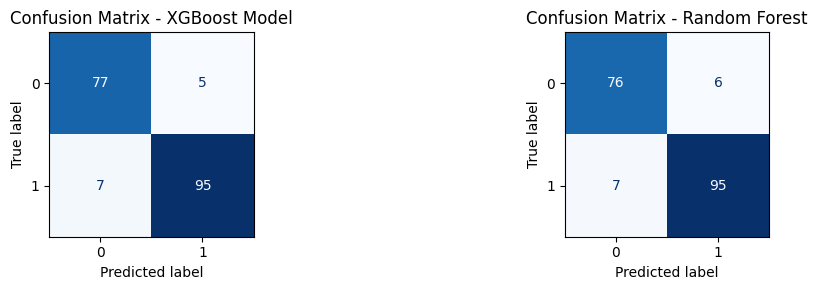

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# -----------------------------
# 9.2.3 Confusion Matrices (Valid Data)
# -----------------------------

# Dictionary: model_name -> (model_object, X_data)
models = {"XGBoost Model": (model_xgb, X_valid_scaled),
          "Random Forest": (model_rf, X_valid_scaled),
         }

plt.figure(figsize=(12, 3))  # wider for 3 plots

for i, (name, (model, X_data)) in enumerate(models.items(), start=1):
    
    # Get probability scores                       # Class predictions  
    y_scores = model.predict_proba(X_data)[:, 1]; y_pred_class = (y_scores >= 0.5).astype(int)
        
    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred_class)
    
    # Plot
    plt.subplot(1, len(models), i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
    plt.title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()

#### **Hyperparameter Tuning Analysis**

After hyperparameter optimization, we re-evaluated **Random Forest** and **XGBoost** on the validation set.

##### **XGBoost (Tuned)**
- **Train Accuracy = 0.9798, Valid Accuracy = 0.9348**  
- **Train ROC AUC = 0.9784, Valid ROC AUC = 0.9842**  
- Classification metrics:  
  - Precision (Class 1) = 0.95  
  - Recall (Class 1) = 0.931  
  - F1-score (Class 1) = 0.941
- **Confusion Matrix (Validation):**
    - `[[77, 5],[ 7, 95]]`
- Correctly classified 172 out of 184 cases.  
- Only **12 misclassifications** (5 false positives, 7 false negatives).  
- High training scores demonstrate strong learning capability, but validation results confirm **good generalization with minimal overfitting**.  
 

##### **Random Forest (Tuned)**
- **Train Accuracy = 0.9190, Valid Accuracy = 0.9293**  
- **Train ROC AUC = 0.9154, Valid ROC AUC = 0.9802**  
- Classification metrics:  
  - Precision (Class 1) = 0.941  
  - Recall (Class 1) = 0.931  
  - F1-score (Class 1) = 0.936
- **Confusion Matrix (Validation):**
    - `[[76, 6],[ 7, 95]]`  
- Correctly classified 171 out of 184 cases.  
- **13 misclassifications** (6 false positives, 7 false negatives).  
- Performance was strong, but slightly below XGBoost in terms of both **validation accuracy** and **ROC AUC**.  

---

#### **Why XGBoost was chosen**
- **Higher Validation Accuracy (93.5% vs 92.9%)**  
- **Higher Validation ROC AUC (0.984 vs 0.980)**, indicating superior class separation.
- **Fewer misclassifications (12 vs 13)** on the validation set.
- Maintained **better balance between precision and recall** compared to Random Forest.  
- Scaled better with tuned parameters and demonstrated **greater robustness on unseen data**.  

**Final Decision:**  
Between the two tuned models, **XGBoost outperformed Random Forest** and was selected as the final model for further training and evaluation.


# **10. Final ML Model (XGBClassifier)**

In this step, we finalize the best-performing model — **XGBoost Classifier** — using the optimal hyperparameters found from the tuning process.  
- We re-fit the model on the **combined training + validation dataset (90%)** and then evaluate it on the **held-out test set (10%)**.  
- Scaling is applied using the same preprocessor built earlier.  
- Final performance metrics (Accuracy, ROC AUC, and Classification Report) are reported for both temporary (train+valid) and test sets.  


In [44]:
# Transform the data using the fitted preprocessor
X_temp_scaled = preprocessor.fit_transform(X_temp) # scaled 90% data (train + valid)
X_test_scaled = preprocessor.transform(X_test) # scaled 10% test data

In [45]:
# Initialize the final XGBClassifier with best hyperparameters from Optuna study
model_xgb_final = XGBClassifier(
    **study_xgb.best_params,
    objective='binary:logistic',
    tree_method ='hist',
    n_jobs=-1,
    eval_metric = 'auc',
    random_state=42,
    verbosity=0,
)
# Fit model on 90% of the data
model_xgb_final.fit(X_temp_scaled, y_temp)

acc_temp, acc_test, proba_temp, proba_test, y_pred_test = metric_cal(model_xgb_final, X_temp_scaled, X_test_scaled, y_temp, y_test)

# Print final evaluation metrics
print(f"Accuracy: Temp = {acc_temp:.4f}; Test = {acc_test:.4f}")
print(f"ROC AUC: Temp = {proba_temp:.4f}; Test = {proba_test:.4f}")

# Classification report for test set
print("\nClassification Report Test:")
cr_dff = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose(); cr_dff.index.name = 'XGBClassifier'
display(cr_dff)

Accuracy: Temp = 0.9758; Test = 0.8587
ROC AUC: Temp = 0.9742; Test = 0.9273

Classification Report Test:


,precision,recall,f1-score,support
XGBClassifier,,,,
0,0.804348,0.902439,0.850575,41.000000
1,0.913043,0.823529,0.865979,51.000000
accuracy,0.858696,0.858696,0.858696,0.858696
macro avg,0.858696,0.862984,0.858277,92.000000
weighted avg,0.864603,0.858696,0.859114,92.000000


# **11. Final Insights**

In this section, we interpret the performance of our final model **(XGBClassifier)** using multiple diagnostic tools:  
- **Confusion Matrix** – to visualize classification errors.  
- **SHAP values** – to understand global and local feature importance.  
- **ROC Curve** – to evaluate discriminative ability on test data.  


## 11.1 Confusion Matrix

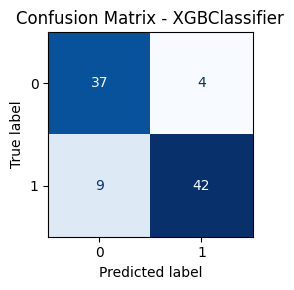

In [46]:
# Predicted probabilities
y_scores = model_xgb_final.predict_proba(X_test_scaled)[:, 1]
    
# Convert to class predictions with 0.5 threshold
y_pred_class = (y_scores >= 0.5).astype(int)
    
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
    
# Plot confusion matrix
plt.figure(figsize=(5,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix - XGBClassifier")

plt.tight_layout()
plt.show()

## 11.2 SHAP (SHapley Additive exPlanations)

SHAP helps explain **how each feature contributes** to the predictions:  
- **Bar plot** → Global feature importance.  
- **Beeswarm plot** → Distribution of feature impacts across samples.  
- **Force plot** → Local explanation for individual predictions.  


=== SHAP Feature Importance for XGBoost ===


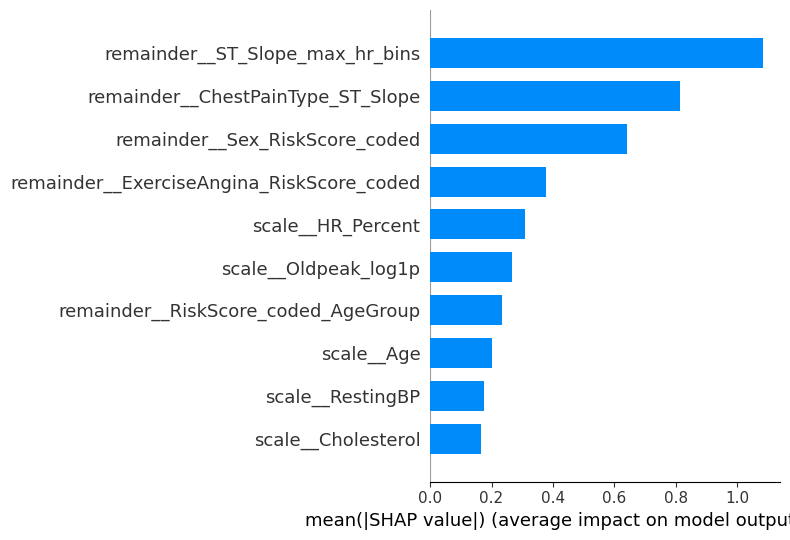

In [47]:
# Convert scaled test data into DataFrame with feature names
X_test_shap = pd.DataFrame(X_test_scaled, columns = preprocessor.get_feature_names_out())

print("=== SHAP Feature Importance for XGBoost ===")

# Initialize SHAP explainer
explainer_xgb = shap.TreeExplainer(model_xgb_final)
shap_values_xgb = explainer_xgb.shap_values(X_test_shap)

# Global importance (bar plot)
shap.summary_plot(shap_values_xgb, X_test_shap, plot_type="bar", show=True)

## 11.3 ROC Curve for XGBClassifier Model on Test Data


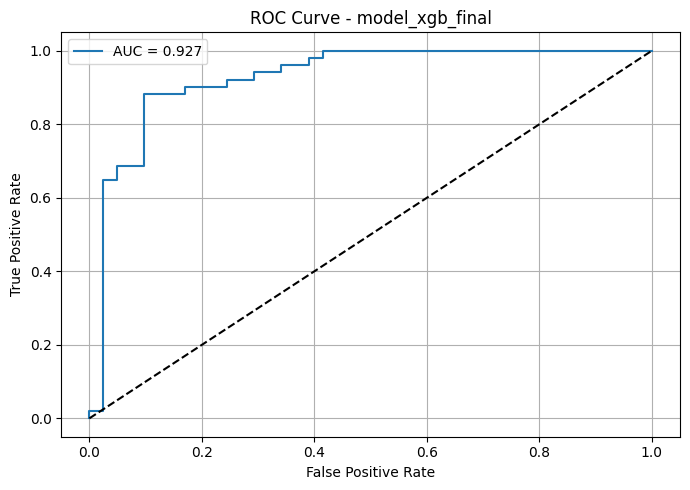

In [48]:
from sklearn.metrics import roc_curve, auc

# Predicted probabilities
y_scores = model_xgb_final.predict_proba(X_test_scaled)[:, 1]

# ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - model_xgb_final')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

---
#### **Insights from Model Evaluation and Feature Importance**

##### **1. Model Performance**
- **Accuracy**:  
  - Training: **97.58%**  
  - Test: **85.87%**
      - The model generalizes well, though a slight performance drop indicates mild overfitting.

- **ROC AUC**:  
  - Training: **0.9742**  
  - Test: **0.9273**
      - The model demonstrates strong discriminative ability on unseen data.

##### **2. Classification Report (Test Data)**
- **Class 0 (No Heart Disease)**:  
  - Precision = **0.80**, Recall = **0.90**, F1-score = **0.85**
      - The model is good at correctly identifying non-disease cases with few false positives.

- **Class 1 (Heart Disease)**:  
  - Precision = **0.91**, Recall = **0.82**, F1-score = **0.87**
      - High precision suggests that when the model predicts disease, it is usually correct, but recall indicates some missed positive cases.

- **Overall**: Balanced performance across both classes, with slightly better detection of non-disease cases.

##### **3. Confusion Matrix**
- `[[37, 4],[ 9, 42]]`
- True Negatives: 37  
- False Positives: 4  
- False Negatives: 9  
- True Positives: 42  

The model makes more errors in **missing positive cases (FN=9)** than in misclassifying negatives (FP=4).  
This suggests that tuning for higher recall could further improve disease detection.

##### **4. Feature Importance (SHAP)**
Top contributing features to model predictions:
1. **ST_Slope_max_hr_bins** (0.95) – Strongest predictor of heart disease risk.  
2. **ChestPainType_ST_Slope** (0.80) – Chest pain in relation to slope is highly informative.  
3. **Sex_RiskScore_coded** (0.71) – Gender-related risk contributes significantly.  
4. **ExerciseAngina_RiskScore_coded** (0.34) and **HR_Percent** (0.33) – Exercise-related variables are also important.  
5. **Oldpeak_log1p, Age, RestingBP, Cholesterol** – Moderate but meaningful influence.  

Overall, **exercise-related, chest pain, and ST slope features** are the dominant predictors.

##### **5. ROC Curve Behavior**
- **True Positive Rate vs. False Positive Rate** analysis shows a well-separated curve.  
- The model maintains **high sensitivity** (>0.90) while keeping false positives relatively low.  

---

# **12. Final Summary**

In this notebook, we developed and evaluated an **XGBoost classifier** for predicting heart disease.  
The model achieved **85.9% accuracy** and a **ROC AUC of 0.93** on the test set, showing strong generalization.  
Analysis of the classification report and confusion matrix highlights balanced precision and recall, though some positive cases are still missed.  

**Key risk factors** identified by SHAP importance include: **ST slope under maximum heart rate, chest pain type, sex-based risk scores, and exercise-induced angina**. These align with established clinical understanding, strengthening the model’s reliability.  

Overall, the notebook demonstrates a **robust and interpretable machine learning pipeline** for heart disease prediction, combining solid performance with valuable clinical insights.  
Future improvements could focus on **reducing false negatives** (missed positive cases) by tuning thresholds or optimizing for higher recall.

---

In [49]:
df[orginal].to_csv('df_original.csv', index=False) # saving data as csv file
df[features + ['HeartDisease']].to_csv('df_final.csv', index=False) # only with final features